## Reproducing a known LJ potential for a composite nanoparticle

In this notebook a composite nanoparticle (a hollow spherical shell of beads) is created and a fictional force field is created for the bead-bead nonbonded interaction. The sum of the bead-bead interactions between two nanoparticles yields the interaction potential at a certain nanoparticle-nanoparticle separation. The interaction potential is evaluated over a series of center-of-mass separations to obtain a set of target data. Our goal here is to take this target data and perform an optimization between these same two composite nanoparticles and return the fictional bead-bead interaction parameters.

Here are various import statements we need...

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mbuild as mb
import numpy as np
from scipy.optimize import fmin

import nanoparticle_optimization as np_opt
from visualize import visualize

Create the composite nanoparticle prototype using the `CG_nano` class from within NanoOpt. This uses a golden spiral algorithm to generate a spherical shell where beads are approximately evenly spaced.

### Nanoparticle details
* **Radius = 5.0 nm**
* **Bead diameter (i.e. $\sigma$) = 1.0 nm**

<IPython.core.display.Javascript object>


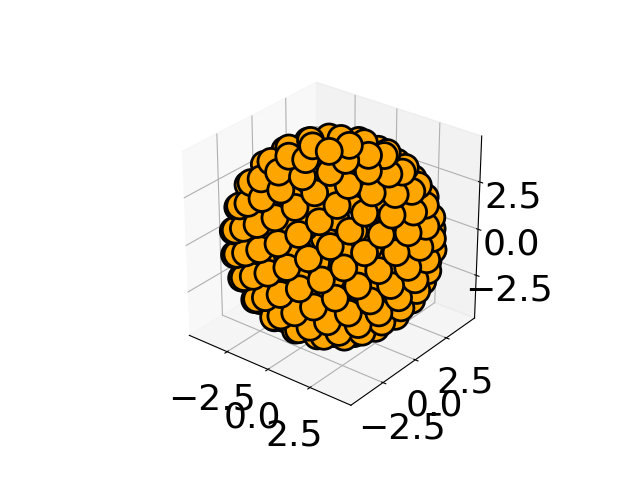

In [2]:
nanoparticle = np_opt.CG_nano(r=5.0, sigma=1.0)
visualize(nanoparticle)

Define a Lennard-Jones potential for bead-bead interactions. Then, using this potential create a set of target data (stored in the `Target` class) that consists of 50 interaction potential values at center-of-mass distances ranging from 10.0nm to 12.0nm. The interaction potential is evaluated at each center-of-mass distance by summing all inter-nanoparticle bead-bead interactions, taking the average over 100 unique configurations.

### Force field parameters
* ** $\sigma$ = 1.0 nm** (this should be the same value as the diameter of the beads)
* ** $\epsilon$ = 1.0 kcal/mol**

<IPython.core.display.Javascript object>


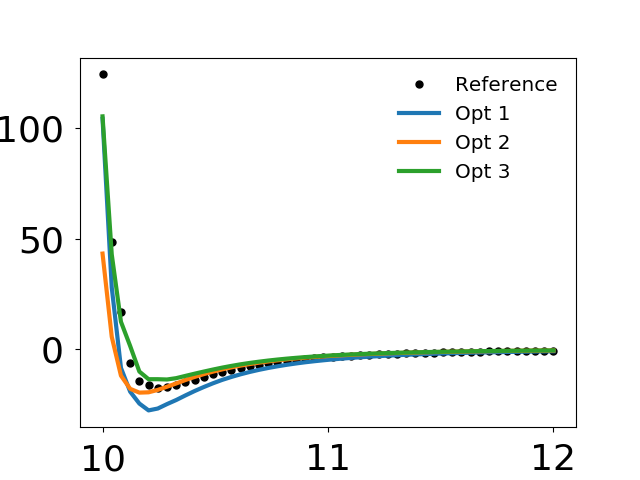

In [27]:
sigma_target = np_opt.Parameter(value=1.0, fixed=True)
epsilon_target = np_opt.Parameter(value=1.0, fixed=True)
lj_target = np_opt.LJ(sigma=sigma_target, epsilon=epsilon_target)

target_system = np_opt.System(nanoparticle)
r = np.linspace(10.0, 12.0, 50)
U = target_system.calc_potential(forcefield=lj_target, separations=r,
                                 configurations=100)
U = np.array([val[0] for val in U])
target = np_opt.Target(separations=r, potential=U)

fig = plt.figure()
plt.plot(r, U, linestyle='None', marker='o', color='black', markersize=5, label='Reference')
plt.legend()
plt.show()

## Reproducing the force field

Now, we will use the same composite nanoparticle prototype and perform an optimization (using the `Optimization` class), where we will optimize the bead-bead interaction parameters (i.e. $\sigma$ and $\epsilon$) in attempt to match the target data (shown on the plot above). If the optimization is successful, we should be able to reproduce the values of $\sigma$ = 1.0 nm and $\epsilon$ = 1.0 kcal/mol that we used to generate the target data.

The optimization consists of two stages:
1. A brute-force optimization where the residual is evaluated at points on a grid spanning the desired parameter space to explore.
2. A polishing stage, whereby starting parameters are chosen as the point from Stage 1 that features the lowest residual. A variety of functions are available for this stage. Here, we will use SciPy's `fmin` which uses a downhill or Nelder-Mead simplex method.

There are a variety of parameters available to us to tune our optimization and can directly influence its success. These parameters are provided in detail below.

### Optimization details
* **Grid points = 8** (how many grid points to consider along each parameter axis)
* **Sigma range = 0.5 nm - 3.5 nm** (the range of values to explore for $\sigma$)
* **Epsilon range = 0.5 kcal/mol - 3.5 kcal/mol** (the range of values to explore for $\epsilon$)
* **Polishing function = scipy.fmin** (Nelder-Mead simplex)
* **Normalize error = True** (normalize the residual by the interaction potential - this provides equal weighting to all points)
* **Number of configurations = 10** (the number of nanoparticle configurations to average over at each center-of-mass separation)
* **Use r-dependent sampling = True** (only sample over the desired number of configurations at short separations - at larger separations additional sampling mostly justs wastes computing time)

In [18]:
grid_spacing = 8 # This parameter name should be changed to grid_points
sigma = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
epsilon = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
lj = np_opt.LJ(sigma=sigma, epsilon=epsilon)
nano2 = np_opt.CG_nano(r=5.0, sigma=1.0)
system = np_opt.System(nano2)
optimization = np_opt.Optimization(forcefield=lj, systems=system, targets=target,
                                   configurations=10, normalize_error=True)
optimization.optimize(grid_spacing=grid_spacing, verbose=True,
                      polishing_function=fmin, r_dependent_sampling=True,
                      maxiter=50)

sigma: 0.5

epsilon: 0.5

Residual: 0.9871997337835768


sigma: 0.5

epsilon: 0.5

Residual: 0.987191723770381


sigma: 0.5

epsilon: 0.9285714285714286

Residual: 0.9767841948421189


sigma: 0.5

epsilon: 1.3571428571428572

Residual: 0.9666932441814517


sigma: 0.5

epsilon: 1.7857142857142856

Residual: 0.9557569603124083


sigma: 0.5

epsilon: 2.2142857142857144

Residual: 0.9460946189582544


sigma: 0.5

epsilon: 2.642857142857143

Residual: 0.9361736632270931


sigma: 0.5

epsilon: 3.071428571428571

Residual: 0.927029503581836


sigma: 0.5

epsilon: 3.5

Residual: 0.9167440564032817


sigma: 0.9285714285714286

epsilon: 0.5

Residual: 0.61203610925493


sigma: 0.9285714285714286

epsilon: 0.9285714285714286

Residual: 0.28039575141618583


sigma: 0.9285714285714286

epsilon: 1.3571428571428572

Residual: 0.22537045338602674


sigma: 0.9285714285714286

epsilon: 1.7857142857142856

Residual: 0.16690583502800838


sigma: 0.9285714285714286

epsilon: 2.2142857142857144

Residual: 0

sigma: 0.9514371599469865

epsilon: 1.7858995710100447

Residual: 0.28720751041101306


sigma: 0.9516234806605748

epsilon: 1.7857551574707033

Residual: 0.2855879379922616


sigma: 0.9519961220877511

epsilon: 1.7854663303920197

Residual: 0.1875867134302204


sigma: 0.9521824428013392

epsilon: 1.7853219168526784

Residual: 0.3591295660738298


sigma: 0.9519479479108539

epsilon: 1.7856734139578683

Residual: 0.27358574562295607


sigma: 0.9518624033246722

epsilon: 1.7855487551007951

Residual: 0.29260393142926566


sigma: 0.9518909181867328

epsilon: 1.7855903080531528

Residual: 0.31774083225050515


sigma: 0.9519150052751814

epsilon: 1.7854867662702285

Residual: 0.2909483671239514


sigma: 0.9520202091761998

epsilon: 1.7853627886090955

Residual: 0.33505276879772494


sigma: 0.9519232409340995

epsilon: 1.7855334281921384

Residual: 0.27737389475315694


sigma: 0.9520043577466691

epsilon: 1.7855129923139297

Residual: 0.19933530740401817


sigma: 0.9520772389003206

epsilon: 

sigma: 0.951994233171254

epsilon: 1.7854593816532622

Residual: 0.22459742518162842


sigma: 0.951994232715684

epsilon: 1.7854593821371432

Residual: 0.23842448616557657


sigma: 0.9519942330573614

epsilon: 1.7854593817742326

Residual: 0.21832147980838987




In [28]:
optimized_U = system.calc_potential(forcefield=optimization.forcefield, separations=r, configurations=100)
plt.plot(r, [val[0] for val in optimized_U], label='Opt 1')
plt.legend()

The results of the optimization are plotted against the target data in the earlier plot and are labelled as 'Opt 1'. As we can see, the optimization was unable to reproduce the known potential. The value of $\sigma$ is pretty close; however, the $\epsilon$ value is considerably off.

We'll see if we can yield better results by tweaking our optimization parameters, specifically using a finer grid during the brute force stage.

### Optimization details
* **Grid points = 15** (how many grid points to consider along each parameter axis)
* **Sigma range = 0.5 nm - 3.5 nm** (the range of values to explore for $\sigma$)
* **Epsilon range = 0.5 kcal/mol - 3.5 kcal/mol** (the range of values to explore for $\epsilon$)
* **Polishing function = scipy.fmin** (Nelder-Mead simplex)
* **Normalize error = True** (normalize the residual by the interaction potential - this provides equal weighting to all points)
* **Number of configurations = 10** (the number of nanoparticle configurations to average over at each center-of-mass separation)
* **Use r-dependent sampling = True** (only sample over the desired number of configurations at short separations - at larger separations additional sampling mostly justs wastes computing time)

In [29]:
grid_spacing = 15
sigma = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
epsilon = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
lj = np_opt.LJ(sigma=sigma, epsilon=epsilon)
nano2 = np_opt.CG_nano(r=5.0, sigma=1.0)
system = np_opt.System(nano2)
optimization = np_opt.Optimization(forcefield=lj, systems=system, targets=target,
                                   configurations=10, normalize_error=True)
optimization.optimize(grid_spacing=grid_spacing, verbose=True,
                      polishing_function=fmin, r_dependent_sampling=True,
                      maxiter=50)

sigma: 0.5

epsilon: 0.5

Residual: 0.9871997337835768


sigma: 0.5

epsilon: 0.5

Residual: 0.987191723770381


sigma: 0.5

epsilon: 0.7142857142857143

Residual: 0.9820689132688224


sigma: 0.5

epsilon: 0.9285714285714286

Residual: 0.9770277876382111


sigma: 0.5

epsilon: 1.1428571428571428

Residual: 0.9713305501238895


sigma: 0.5

epsilon: 1.3571428571428572

Residual: 0.9664268402554145


sigma: 0.5

epsilon: 1.5714285714285714

Residual: 0.961312562449264


sigma: 0.5

epsilon: 1.7857142857142856

Residual: 0.9565767164717007


sigma: 0.5

epsilon: 2.0

Residual: 0.9511069651023722


sigma: 0.5

epsilon: 2.2142857142857144

Residual: 0.945536923043973


sigma: 0.5

epsilon: 2.4285714285714284

Residual: 0.9409884537269715


sigma: 0.5

epsilon: 2.642857142857143

Residual: 0.9346496448449803


sigma: 0.5

epsilon: 2.857142857142857

Residual: 0.9283566115998304


sigma: 0.5

epsilon: 3.071428571428571

Residual: 0.9271211154459069


sigma: 0.5

epsilon: 3.2857142857142856

Re

sigma: 1.7857142857142856

epsilon: 2.642857142857143

Residual: 0.9995801292979891


sigma: 1.7857142857142856

epsilon: 2.857142857142857

Residual: 0.9995191685677889


sigma: 1.7857142857142856

epsilon: 3.071428571428571

Residual: 0.9997216514547499


sigma: 1.7857142857142856

epsilon: 3.2857142857142856

Residual: 0.9998111448830113


sigma: 1.7857142857142856

epsilon: 3.5

Residual: 0.9996579216713554


sigma: 2.0

epsilon: 0.5

Residual: 0.9996509497602635


sigma: 2.0

epsilon: 0.7142857142857143

Residual: 0.999552289443117


sigma: 2.0

epsilon: 0.9285714285714286

Residual: 0.9998351564450285


sigma: 2.0

epsilon: 1.1428571428571428

Residual: 0.9996909923936191


sigma: 2.0

epsilon: 1.3571428571428572

Residual: 0.9997701081942623


sigma: 2.0

epsilon: 1.5714285714285714

Residual: 0.9998630994089086


sigma: 2.0

epsilon: 1.7857142857142856

Residual: 0.9998346617523086


sigma: 2.0

epsilon: 2.0

Residual: 0.999869774424416


sigma: 2.0

epsilon: 2.2142857142857144

sigma: 3.2857142857142856

epsilon: 2.0

Residual: 0.9999996751284843


sigma: 3.2857142857142856

epsilon: 2.2142857142857144

Residual: 0.9999997837495892


sigma: 3.2857142857142856

epsilon: 2.4285714285714284

Residual: 0.9999998137588297


sigma: 3.2857142857142856

epsilon: 2.642857142857143

Residual: 0.9999998256277708


sigma: 3.2857142857142856

epsilon: 2.857142857142857

Residual: 0.9999998704323972


sigma: 3.2857142857142856

epsilon: 3.071428571428571

Residual: 0.9999998806319901


sigma: 3.2857142857142856

epsilon: 3.2857142857142856

Residual: 0.9999998684365193


sigma: 3.2857142857142856

epsilon: 3.5

Residual: 0.9999998511345802


sigma: 3.5

epsilon: 0.5

Residual: 0.9999994356493216


sigma: 3.5

epsilon: 0.7142857142857143

Residual: 0.9999992903126063


sigma: 3.5

epsilon: 0.9285714285714286

Residual: 0.999999724870968


sigma: 3.5

epsilon: 1.1428571428571428

Residual: 0.9999997948181624


sigma: 3.5

epsilon: 1.3571428571428572

Residual: 0.999999844966

sigma: 0.919866205645459

epsilon: 1.4334817343524526

Residual: 0.24109042462395344


sigma: 0.9198668642767838

epsilon: 1.433482462380614

Residual: 0.3620818759651559


sigma: 0.9198654127972465

epsilon: 1.4334814148289818

Residual: 0.29037401699335286


sigma: 0.9198657756671309

epsilon: 1.4334816767168899

Residual: 0.2106179367651957


sigma: 0.9198656414502433

epsilon: 1.4334820852215802

Residual: 0.27940547292643575


sigma: 0.919866064596655

epsilon: 1.4334818220697345

Residual: 0.24940034043833925


sigma: 0.9198659235478511

epsilon: 1.4334819097870164

Residual: 0.32174098807919943


sigma: 0.9198661385370152

epsilon: 1.433481938604798

Residual: 0.24682120741317173


sigma: 0.9198662864177353

epsilon: 1.4334821716749246

Residual: 0.30534119365977047


sigma: 0.9198661957002643

epsilon: 1.4334821062029477

Residual: 0.30954338330423886


sigma: 0.9198661049827932

epsilon: 1.4334820407309705

Residual: 0.26399676460933347


sigma: 0.9198659974882113

epsilon: 1.

In [30]:
optimized_U = system.calc_potential(forcefield=optimization.forcefield, separations=r, configurations=100)
plt.plot(r, [val[0] for val in optimized_U], label='Opt 2')
plt.legend()

The results of the second optimization are plotted against the target data in the earlier plot and are labelled as 'Opt 2'. Again we see that the optimization was unable to reproduce the known potential.

We'll now run a third optimization with an even finer grid.

### Optimization details
* **Grid points = 25** (how many grid points to consider along each parameter axis)
* **Sigma range = 0.5 nm - 3.5 nm** (the range of values to explore for $\sigma$)
* **Epsilon range = 0.5 kcal/mol - 3.5 kcal/mol** (the range of values to explore for $\epsilon$)
* **Polishing function = scipy.fmin** (Nelder-Mead simplex)
* **Normalize error = True** (normalize the residual by the interaction potential - this provides equal weighting to all points)
* **Number of configurations = 10** (the number of nanoparticle configurations to average over at each center-of-mass separation)
* **Use r-dependent sampling = True** (only sample over the desired number of configurations at short separations - at larger separations additional sampling mostly justs wastes computing time)

In [31]:
grid_spacing = 25
sigma = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
epsilon = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
lj = np_opt.LJ(sigma=sigma, epsilon=epsilon)
nano2 = np_opt.CG_nano(r=5.0, sigma=1.0)
system = np_opt.System(nano2)
optimization = np_opt.Optimization(forcefield=lj, systems=system, targets=target,
                                   configurations=10, normalize_error=True)
optimization.optimize(grid_spacing=grid_spacing, verbose=True,
                      polishing_function=fmin, r_dependent_sampling=True,
                      maxiter=50)

sigma: 0.5

epsilon: 0.5

Residual: 0.9871997337835768


sigma: 0.5

epsilon: 0.5

Residual: 0.987191723770381


sigma: 0.5

epsilon: 0.625

Residual: 0.9842836130961006


sigma: 0.5

epsilon: 0.75

Residual: 0.9813831006573064


sigma: 0.5

epsilon: 0.875

Residual: 0.9779350437274092


sigma: 0.5

epsilon: 1.0

Residual: 0.9750940341509023


sigma: 0.5

epsilon: 1.125

Residual: 0.9720774829445115


sigma: 0.5

epsilon: 1.25

Residual: 0.9693026421526225


sigma: 0.5

epsilon: 1.375

Residual: 0.9659934306584609


sigma: 0.5

epsilon: 1.5

Residual: 0.9626114704984171


sigma: 0.5

epsilon: 1.625

Residual: 0.9599101627264911


sigma: 0.5

epsilon: 1.75

Residual: 0.9559901636151441


sigma: 0.5

epsilon: 1.875

Residual: 0.9520812375909887


sigma: 0.5

epsilon: 2.0

Residual: 0.9516067565259955


sigma: 0.5

epsilon: 2.125

Residual: 0.9490191611687803


sigma: 0.5

epsilon: 2.25

Residual: 0.945499968687069


sigma: 0.5

epsilon: 2.375

Residual: 0.9432629755170199


sigma: 0.5

e

sigma: 1.125

epsilon: 2.125

Residual: 0.800295500699825


sigma: 1.125

epsilon: 2.25

Residual: 0.6656802013930662


sigma: 1.125

epsilon: 2.375

Residual: 0.7638411064134661


sigma: 1.125

epsilon: 2.5

Residual: 0.820603538693072


sigma: 1.125

epsilon: 2.625

Residual: 0.7992012678504203


sigma: 1.125

epsilon: 2.75

Residual: 0.8065144394561836


sigma: 1.125

epsilon: 2.875

Residual: 0.9009123851414284


sigma: 1.125

epsilon: 3.0

Residual: 0.8229174239339228


sigma: 1.125

epsilon: 3.125

Residual: 0.7937078888188204


sigma: 1.125

epsilon: 3.25

Residual: 0.7827045862572705


sigma: 1.125

epsilon: 3.375

Residual: 0.8806145338094709


sigma: 1.125

epsilon: 3.5

Residual: 0.8868253350214554


sigma: 1.25

epsilon: 0.5

Residual: 0.8277935446805345


sigma: 1.25

epsilon: 0.625

Residual: 0.8502389987425679


sigma: 1.25

epsilon: 0.75

Residual: 0.8665567565282792


sigma: 1.25

epsilon: 0.875

Residual: 0.8936402635942767


sigma: 1.25

epsilon: 1.0

Residual: 0.840

sigma: 1.875

epsilon: 0.75

Residual: 0.9994074863848141


sigma: 1.875

epsilon: 0.875

Residual: 0.9989629555949312


sigma: 1.875

epsilon: 1.0

Residual: 0.9992416835899776


sigma: 1.875

epsilon: 1.125

Residual: 0.9994788356835296


sigma: 1.875

epsilon: 1.25

Residual: 0.999302702361353


sigma: 1.875

epsilon: 1.375

Residual: 0.9995208615514487


sigma: 1.875

epsilon: 1.5

Residual: 0.9995970316021272


sigma: 1.875

epsilon: 1.625

Residual: 0.999707783196197


sigma: 1.875

epsilon: 1.75

Residual: 0.9996580591858093


sigma: 1.875

epsilon: 1.875

Residual: 0.999648944400786


sigma: 1.875

epsilon: 2.0

Residual: 0.9996621196541869


sigma: 1.875

epsilon: 2.125

Residual: 0.9996956530749702


sigma: 1.875

epsilon: 2.25

Residual: 0.9997864334695565


sigma: 1.875

epsilon: 2.375

Residual: 0.9997550947765804


sigma: 1.875

epsilon: 2.5

Residual: 0.9997199679060885


sigma: 1.875

epsilon: 2.625

Residual: 0.999781241364232


sigma: 1.875

epsilon: 2.75

Residual: 0

sigma: 2.5

epsilon: 2.5

Residual: 0.9999918501687699


sigma: 2.5

epsilon: 2.625

Residual: 0.9999936393278953


sigma: 2.5

epsilon: 2.75

Residual: 0.9999935335789116


sigma: 2.5

epsilon: 2.875

Residual: 0.9999952234974308


sigma: 2.5

epsilon: 3.0

Residual: 0.9999959334791413


sigma: 2.5

epsilon: 3.125

Residual: 0.9999947902075426


sigma: 2.5

epsilon: 3.25

Residual: 0.9999946886801463


sigma: 2.5

epsilon: 3.375

Residual: 0.9999961547228516


sigma: 2.5

epsilon: 3.5

Residual: 0.9999960920969055


sigma: 2.625

epsilon: 0.5

Residual: 0.9999888123848313


sigma: 2.625

epsilon: 0.625

Residual: 0.9999872993616794


sigma: 2.625

epsilon: 0.75

Residual: 0.9999916888070702


sigma: 2.625

epsilon: 0.875

Residual: 0.9999927647688852


sigma: 2.625

epsilon: 1.0

Residual: 0.9999886734236118


sigma: 2.625

epsilon: 1.125

Residual: 0.999993333719561


sigma: 2.625

epsilon: 1.25

Residual: 0.9999942831689925


sigma: 2.625

epsilon: 1.375

Residual: 0.999992453552538

sigma: 3.25

epsilon: 1.0

Residual: 0.9999993143540481


sigma: 3.25

epsilon: 1.125

Residual: 0.9999995008272552


sigma: 3.25

epsilon: 1.25

Residual: 0.9999996092312606


sigma: 3.25

epsilon: 1.375

Residual: 0.9999995511611144


sigma: 3.25

epsilon: 1.5

Residual: 0.9999995901207877


sigma: 3.25

epsilon: 1.625

Residual: 0.9999994948825832


sigma: 3.25

epsilon: 1.75

Residual: 0.9999996459626233


sigma: 3.25

epsilon: 1.875

Residual: 0.9999997913552028


sigma: 3.25

epsilon: 2.0

Residual: 0.9999997455561116


sigma: 3.25

epsilon: 2.125

Residual: 0.9999996992674134


sigma: 3.25

epsilon: 2.25

Residual: 0.9999996753066532


sigma: 3.25

epsilon: 2.375

Residual: 0.9999998758027644


sigma: 3.25

epsilon: 2.5

Residual: 0.9999997469714166


sigma: 3.25

epsilon: 2.625

Residual: 0.9999997555550667


sigma: 3.25

epsilon: 2.75

Residual: 0.999999866514862


sigma: 3.25

epsilon: 2.875

Residual: 0.9999997545975849


sigma: 3.25

epsilon: 3.0

Residual: 0.99999980336285

sigma: 1.0073715209960936

epsilon: 0.7813739776611329

Residual: 0.1653996335823182


sigma: 1.0073740005493166

epsilon: 0.7813815593719484

Residual: 0.2044121710452192


sigma: 1.0073853492736817

epsilon: 0.7813711881637575

Residual: 0.17688562719354786


sigma: 1.007408046722412

epsilon: 0.7813504457473757

Residual: 0.1526874387209142


sigma: 1.0074584007263183

epsilon: 0.7813241243362429

Residual: 0.15727157087094296


sigma: 1.007436680793762

epsilon: 0.7813365876674654

Residual: 0.27158521292625104


sigma: 1.007414960861206

epsilon: 0.7813490509986879

Residual: 0.15479922883634548


sigma: 1.0073966979980469

epsilon: 0.7813608169555666

Residual: 0.19455368771148393


sigma: 1.007440137863159

epsilon: 0.7813358902931213

Residual: 0.21571487530162303


sigma: 1.007407557964325

epsilon: 0.7813545852899553

Residual: 0.153251970890084


sigma: 1.0074144721031186

epsilon: 0.7813531905412675

Residual: 0.29145104560406676


sigma: 1.0074148386716841

epsilon: 0.7813

In [32]:
optimized_U = system.calc_potential(forcefield=optimization.forcefield, separations=r, configurations=100)
plt.plot(r, [val[0] for val in optimized_U], label='Opt 3')
plt.legend()

Improvement. But still not as close as we would like. There is still about a 22% error in the $\epsilon$ value.

This is frustrating. Now we'll set up an optimization with an extremely fine grid. 100 grid points along each parameter axis.

### Optimization details
* **Grid points = 100** (how many grid points to consider along each parameter axis)
* **Sigma range = 0.5 nm - 3.5 nm** (the range of values to explore for $\sigma$)
* **Epsilon range = 0.5 kcal/mol - 3.5 kcal/mol** (the range of values to explore for $\epsilon$)
* **Polishing function = scipy.fmin** (Nelder-Mead simplex)
* **Normalize error = True** (normalize the residual by the interaction potential - this provides equal weighting to all points)
* **Number of configurations = 1** (the number of nanoparticle configurations to average over at each center-of-mass separation)
* **Use r-dependent sampling = True** (only sample over the desired number of configurations at short separations - at larger separations additional sampling mostly justs wastes computing time)

In [13]:
# Set up optimization
grid_spacing = 100
sigma = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
epsilon = np_opt.Parameter(value=1., upper=3.5, lower=0.5)
lj = np_opt.LJ(sigma=sigma, epsilon=epsilon)
nano2 = np_opt.CG_nano(r=5.0, sigma=1.0)
system = np_opt.System(nano2)
optimization = np_opt.Optimization(forcefield=lj, systems=system, targets=target,
                                   configurations=1, normalize_error=True)
optimization.optimize(grid_spacing=grid_spacing, verbose=True,
                      polishing_function=fmin, r_dependent_sampling=True,
                      maxiter=50)

sigma: 0.5

epsilon: 0.5

Residual: 0.9873843306888901


sigma: 0.5

epsilon: 0.5

Residual: 0.9874634830560748


sigma: 0.5

epsilon: 0.5303030303030303

Residual: 0.9867291728188057


sigma: 0.5

epsilon: 0.5606060606060606

Residual: 0.9855323277642752


sigma: 0.5

epsilon: 0.5909090909090909

Residual: 0.9852462550683775


sigma: 0.5

epsilon: 0.6212121212121212

Residual: 0.9841766655605712


sigma: 0.5

epsilon: 0.6515151515151515

Residual: 0.9836395672627233


sigma: 0.5

epsilon: 0.6818181818181819

Residual: 0.9826955531181674


sigma: 0.5

epsilon: 0.7121212121212122

Residual: 0.982355285694336


sigma: 0.5

epsilon: 0.7424242424242424

Residual: 0.981354734922461


sigma: 0.5

epsilon: 0.7727272727272727

Residual: 0.9803510260185357


sigma: 0.5

epsilon: 0.803030303030303

Residual: 0.9797860532034371


sigma: 0.5

epsilon: 0.8333333333333334

Residual: 0.9789495590198692


sigma: 0.5

epsilon: 0.8636363636363636

Residual: 0.9782207033587722


sigma: 0.5

epsilon: 0.89

sigma: 0.5303030303030303

epsilon: 0.8939393939393939

Residual: 0.9678460796263408


sigma: 0.5303030303030303

epsilon: 0.9242424242424243

Residual: 0.9677379354999134


sigma: 0.5303030303030303

epsilon: 0.9545454545454546

Residual: 0.9655571036528465


sigma: 0.5303030303030303

epsilon: 0.9848484848484849

Residual: 0.964881298459872


sigma: 0.5303030303030303

epsilon: 1.0151515151515151

Residual: 0.9648123203940533


sigma: 0.5303030303030303

epsilon: 1.0454545454545454

Residual: 0.9637854837719423


sigma: 0.5303030303030303

epsilon: 1.0757575757575757

Residual: 0.9621656742319399


sigma: 0.5303030303030303

epsilon: 1.106060606060606

Residual: 0.9612005778423924


sigma: 0.5303030303030303

epsilon: 1.1363636363636362

Residual: 0.9605614401763913


sigma: 0.5303030303030303

epsilon: 1.1666666666666667

Residual: 0.959030401670928


sigma: 0.5303030303030303

epsilon: 1.196969696969697

Residual: 0.9577165666839155


sigma: 0.5303030303030303

epsilon: 1.227272727

sigma: 0.5606060606060606

epsilon: 0.7727272727272727

Residual: 0.9620035108870413


sigma: 0.5606060606060606

epsilon: 0.803030303030303

Residual: 0.9613148314849379


sigma: 0.5606060606060606

epsilon: 0.8333333333333334

Residual: 0.9595653789306366


sigma: 0.5606060606060606

epsilon: 0.8636363636363636

Residual: 0.9585142184860738


sigma: 0.5606060606060606

epsilon: 0.8939393939393939

Residual: 0.9556818967102291


sigma: 0.5606060606060606

epsilon: 0.9242424242424243

Residual: 0.9559779949205751


sigma: 0.5606060606060606

epsilon: 0.9545454545454546

Residual: 0.9540448808951832


sigma: 0.5606060606060606

epsilon: 0.9848484848484849

Residual: 0.9526297324703574


sigma: 0.5606060606060606

epsilon: 1.0151515151515151

Residual: 0.9513619195817565


sigma: 0.5606060606060606

epsilon: 1.0454545454545454

Residual: 0.9496824225080273


sigma: 0.5606060606060606

epsilon: 1.0757575757575757

Residual: 0.9487227943103312


sigma: 0.5606060606060606

epsilon: 1.106060

sigma: 0.5909090909090909

epsilon: 0.6515151515151515

Residual: 0.9575285152780995


sigma: 0.5909090909090909

epsilon: 0.6818181818181819

Residual: 0.955447046937472


sigma: 0.5909090909090909

epsilon: 0.7121212121212122

Residual: 0.9527688041555424


sigma: 0.5909090909090909

epsilon: 0.7424242424242424

Residual: 0.9504649900695403


sigma: 0.5909090909090909

epsilon: 0.7727272727272727

Residual: 0.9495892760970185


sigma: 0.5909090909090909

epsilon: 0.803030303030303

Residual: 0.9469320688092477


sigma: 0.5909090909090909

epsilon: 0.8333333333333334

Residual: 0.9452256715450812


sigma: 0.5909090909090909

epsilon: 0.8636363636363636

Residual: 0.943296940560987


sigma: 0.5909090909090909

epsilon: 0.8939393939393939

Residual: 0.94001097108389


sigma: 0.5909090909090909

epsilon: 0.9242424242424243

Residual: 0.9398463914450398


sigma: 0.5909090909090909

epsilon: 0.9545454545454546

Residual: 0.9372232782098107


sigma: 0.5909090909090909

epsilon: 0.9848484848

sigma: 0.6212121212121212

epsilon: 0.5303030303030303

Residual: 0.9516198911121084


sigma: 0.6212121212121212

epsilon: 0.5606060606060606

Residual: 0.949450940868537


sigma: 0.6212121212121212

epsilon: 0.5909090909090909

Residual: 0.947771839868908


sigma: 0.6212121212121212

epsilon: 0.6212121212121212

Residual: 0.9442707583896215


sigma: 0.6212121212121212

epsilon: 0.6515151515151515

Residual: 0.9439637618981618


sigma: 0.6212121212121212

epsilon: 0.6818181818181819

Residual: 0.940288959881239


sigma: 0.6212121212121212

epsilon: 0.7121212121212122

Residual: 0.9373728589858454


sigma: 0.6212121212121212

epsilon: 0.7424242424242424

Residual: 0.93389981472666


sigma: 0.6212121212121212

epsilon: 0.7727272727272727

Residual: 0.9331871187029952


sigma: 0.6212121212121212

epsilon: 0.803030303030303

Residual: 0.929358098177091


sigma: 0.6212121212121212

epsilon: 0.8333333333333334

Residual: 0.9281116855191289


sigma: 0.6212121212121212

epsilon: 0.863636363636

sigma: 0.6212121212121212

epsilon: 3.4696969696969697

Residual: 0.7498652188030718


sigma: 0.6212121212121212

epsilon: 3.5

Residual: 0.7483930360701175


sigma: 0.6515151515151515

epsilon: 0.5

Residual: 0.9407877711652487


sigma: 0.6515151515151515

epsilon: 0.5303030303030303

Residual: 0.9367577154526194


sigma: 0.6515151515151515

epsilon: 0.5606060606060606

Residual: 0.9342465410866734


sigma: 0.6515151515151515

epsilon: 0.5909090909090909

Residual: 0.9307711862675806


sigma: 0.6515151515151515

epsilon: 0.6212121212121212

Residual: 0.9273577491002397


sigma: 0.6515151515151515

epsilon: 0.6515151515151515

Residual: 0.9247665072220056


sigma: 0.6515151515151515

epsilon: 0.6818181818181819

Residual: 0.9218072450650504


sigma: 0.6515151515151515

epsilon: 0.7121212121212122

Residual: 0.9194383514906573


sigma: 0.6515151515151515

epsilon: 0.7424242424242424

Residual: 0.9132266200724743


sigma: 0.6515151515151515

epsilon: 0.7727272727272727

Residual: 0.91188

sigma: 0.6515151515151515

epsilon: 3.378787878787879

Residual: 0.6913956281243867


sigma: 0.6515151515151515

epsilon: 3.409090909090909

Residual: 0.6956469958805223


sigma: 0.6515151515151515

epsilon: 3.4393939393939394

Residual: 0.6937552832289773


sigma: 0.6515151515151515

epsilon: 3.4696969696969697

Residual: 0.6941688928982378


sigma: 0.6515151515151515

epsilon: 3.5

Residual: 0.6900806105176778


sigma: 0.6818181818181819

epsilon: 0.5

Residual: 0.9233127706817296


sigma: 0.6818181818181819

epsilon: 0.5303030303030303

Residual: 0.91940195926793


sigma: 0.6818181818181819

epsilon: 0.5606060606060606

Residual: 0.9162079975258821


sigma: 0.6818181818181819

epsilon: 0.5909090909090909

Residual: 0.9114219922909117


sigma: 0.6818181818181819

epsilon: 0.6212121212121212

Residual: 0.9058666785878905


sigma: 0.6818181818181819

epsilon: 0.6515151515151515

Residual: 0.9026952748914973


sigma: 0.6818181818181819

epsilon: 0.6818181818181819

Residual: 0.899914591

sigma: 0.6818181818181819

epsilon: 3.257575757575758

Residual: 0.6449722334212183


sigma: 0.6818181818181819

epsilon: 3.287878787878788

Residual: 0.6438176746329966


sigma: 0.6818181818181819

epsilon: 3.3181818181818183

Residual: 0.6389504999160415


sigma: 0.6818181818181819

epsilon: 3.3484848484848486

Residual: 0.6390360214802024


sigma: 0.6818181818181819

epsilon: 3.378787878787879

Residual: 0.6401492920081546


sigma: 0.6818181818181819

epsilon: 3.409090909090909

Residual: 0.6307062680700933


sigma: 0.6818181818181819

epsilon: 3.4393939393939394

Residual: 0.6267917577879082


sigma: 0.6818181818181819

epsilon: 3.4696969696969697

Residual: 0.6283689930198882


sigma: 0.6818181818181819

epsilon: 3.5

Residual: 0.6258924363605219


sigma: 0.7121212121212122

epsilon: 0.5

Residual: 0.9056777234662098


sigma: 0.7121212121212122

epsilon: 0.5303030303030303

Residual: 0.898304037561254


sigma: 0.7121212121212122

epsilon: 0.5606060606060606

Residual: 0.8933310896

sigma: 0.7121212121212122

epsilon: 3.1363636363636362

Residual: 0.590719847584952


sigma: 0.7121212121212122

epsilon: 3.166666666666667

Residual: 0.5893118841443361


sigma: 0.7121212121212122

epsilon: 3.1969696969696972

Residual: 0.5833232890030773


sigma: 0.7121212121212122

epsilon: 3.2272727272727275

Residual: 0.5781559665826925


sigma: 0.7121212121212122

epsilon: 3.257575757575758

Residual: 0.5810249188795326


sigma: 0.7121212121212122

epsilon: 3.287878787878788

Residual: 0.5757937534559283


sigma: 0.7121212121212122

epsilon: 3.3181818181818183

Residual: 0.5735606751438482


sigma: 0.7121212121212122

epsilon: 3.3484848484848486

Residual: 0.5672790609806456


sigma: 0.7121212121212122

epsilon: 3.378787878787879

Residual: 0.5746157360195348


sigma: 0.7121212121212122

epsilon: 3.409090909090909

Residual: 0.5682550751453315


sigma: 0.7121212121212122

epsilon: 3.4393939393939394

Residual: 0.5669186188465237


sigma: 0.7121212121212122

epsilon: 3.46969696969

sigma: 0.7424242424242424

epsilon: 3.015151515151515

Residual: 0.5330105009921118


sigma: 0.7424242424242424

epsilon: 3.0454545454545454

Residual: 0.539482900438694


sigma: 0.7424242424242424

epsilon: 3.0757575757575757

Residual: 0.5340329299324181


sigma: 0.7424242424242424

epsilon: 3.106060606060606

Residual: 0.5279215283105574


sigma: 0.7424242424242424

epsilon: 3.1363636363636362

Residual: 0.5162649001482726


sigma: 0.7424242424242424

epsilon: 3.166666666666667

Residual: 0.5144519486209637


sigma: 0.7424242424242424

epsilon: 3.1969696969696972

Residual: 0.5209537295471622


sigma: 0.7424242424242424

epsilon: 3.2272727272727275

Residual: 0.5031642936095191


sigma: 0.7424242424242424

epsilon: 3.257575757575758

Residual: 0.5053236575191389


sigma: 0.7424242424242424

epsilon: 3.287878787878788

Residual: 0.5085702936250333


sigma: 0.7424242424242424

epsilon: 3.3181818181818183

Residual: 0.5152811048261258


sigma: 0.7424242424242424

epsilon: 3.34848484848

sigma: 0.7727272727272727

epsilon: 2.893939393939394

Residual: 0.47602833183354487


sigma: 0.7727272727272727

epsilon: 2.9242424242424243

Residual: 0.4770751294211875


sigma: 0.7727272727272727

epsilon: 2.9545454545454546

Residual: 0.4483290341795139


sigma: 0.7727272727272727

epsilon: 2.984848484848485

Residual: 0.47595618536568246


sigma: 0.7727272727272727

epsilon: 3.015151515151515

Residual: 0.4656855821323728


sigma: 0.7727272727272727

epsilon: 3.0454545454545454

Residual: 0.48241549891992386


sigma: 0.7727272727272727

epsilon: 3.0757575757575757

Residual: 0.4706360774381852


sigma: 0.7727272727272727

epsilon: 3.106060606060606

Residual: 0.45934421012114274


sigma: 0.7727272727272727

epsilon: 3.1363636363636362

Residual: 0.453603930978637


sigma: 0.7727272727272727

epsilon: 3.166666666666667

Residual: 0.4669633939539543


sigma: 0.7727272727272727

epsilon: 3.1969696969696972

Residual: 0.4620955154096402


sigma: 0.7727272727272727

epsilon: 3.2272727

sigma: 0.803030303030303

epsilon: 2.772727272727273

Residual: 0.4374150027103647


sigma: 0.803030303030303

epsilon: 2.803030303030303

Residual: 0.31186117539107544


sigma: 0.803030303030303

epsilon: 2.8333333333333335

Residual: 0.3672551246217637


sigma: 0.803030303030303

epsilon: 2.8636363636363638

Residual: 0.44477287695992307


sigma: 0.803030303030303

epsilon: 2.893939393939394

Residual: 0.43680797470337324


sigma: 0.803030303030303

epsilon: 2.9242424242424243

Residual: 0.4385598313525597


sigma: 0.803030303030303

epsilon: 2.9545454545454546

Residual: 0.41641682796582874


sigma: 0.803030303030303

epsilon: 2.984848484848485

Residual: 0.37981953867711216


sigma: 0.803030303030303

epsilon: 3.015151515151515

Residual: 0.4182044576761665


sigma: 0.803030303030303

epsilon: 3.0454545454545454

Residual: 0.3983141981334307


sigma: 0.803030303030303

epsilon: 3.0757575757575757

Residual: 0.4136499372789745


sigma: 0.803030303030303

epsilon: 3.106060606060606



sigma: 0.8333333333333334

epsilon: 2.6818181818181817

Residual: 0.4030250018194874


sigma: 0.8333333333333334

epsilon: 2.7121212121212124

Residual: 0.3819907610758188


sigma: 0.8333333333333334

epsilon: 2.7424242424242427

Residual: 0.4124801304639986


sigma: 0.8333333333333334

epsilon: 2.772727272727273

Residual: 0.4120462129288939


sigma: 0.8333333333333334

epsilon: 2.803030303030303

Residual: 0.4085944368236286


sigma: 0.8333333333333334

epsilon: 2.8333333333333335

Residual: 0.23085748340704804


sigma: 0.8333333333333334

epsilon: 2.8636363636363638

Residual: 0.39299301121470853


sigma: 0.8333333333333334

epsilon: 2.893939393939394

Residual: 0.4058796865508959


sigma: 0.8333333333333334

epsilon: 2.9242424242424243

Residual: 0.4080837644884467


sigma: 0.8333333333333334

epsilon: 2.9545454545454546

Residual: 0.38526757514547494


sigma: 0.8333333333333334

epsilon: 2.984848484848485

Residual: 0.3187227470150002


sigma: 0.8333333333333334

epsilon: 3.015151

sigma: 0.8636363636363636

epsilon: 2.5303030303030303

Residual: 0.38091875358229393


sigma: 0.8636363636363636

epsilon: 2.5606060606060606

Residual: 0.322793381595087


sigma: 0.8636363636363636

epsilon: 2.590909090909091

Residual: 0.3368657980917436


sigma: 0.8636363636363636

epsilon: 2.621212121212121

Residual: 0.39406365252017084


sigma: 0.8636363636363636

epsilon: 2.6515151515151514

Residual: 0.4278179360349789


sigma: 0.8636363636363636

epsilon: 2.6818181818181817

Residual: 0.4162866265707648


sigma: 0.8636363636363636

epsilon: 2.7121212121212124

Residual: 0.3937836066487331


sigma: 0.8636363636363636

epsilon: 2.7424242424242427

Residual: 0.3061892524786402


sigma: 0.8636363636363636

epsilon: 2.772727272727273

Residual: 0.4045514624566873


sigma: 0.8636363636363636

epsilon: 2.803030303030303

Residual: 0.4239509167496896


sigma: 0.8636363636363636

epsilon: 2.8333333333333335

Residual: 0.4247959850337166


sigma: 0.8636363636363636

epsilon: 2.86363636

sigma: 0.8939393939393939

epsilon: 2.409090909090909

Residual: 0.3698700182984438


sigma: 0.8939393939393939

epsilon: 2.4393939393939394

Residual: 0.4024377622160109


sigma: 0.8939393939393939

epsilon: 2.4696969696969697

Residual: 0.3015969418885735


sigma: 0.8939393939393939

epsilon: 2.5

Residual: 0.24358166936159203


sigma: 0.8939393939393939

epsilon: 2.5303030303030303

Residual: 0.33901611303469154


sigma: 0.8939393939393939

epsilon: 2.5606060606060606

Residual: 0.44028596824973354


sigma: 0.8939393939393939

epsilon: 2.590909090909091

Residual: 0.36109722698249896


sigma: 0.8939393939393939

epsilon: 2.621212121212121

Residual: 0.36935131910446695


sigma: 0.8939393939393939

epsilon: 2.6515151515151514

Residual: 0.4613689431553177


sigma: 0.8939393939393939

epsilon: 2.6818181818181817

Residual: 0.4167873387931608


sigma: 0.8939393939393939

epsilon: 2.7121212121212124

Residual: 0.3378270558513559


sigma: 0.8939393939393939

epsilon: 2.7424242424242427



sigma: 0.9242424242424243

epsilon: 2.287878787878788

Residual: 0.4674479122287022


sigma: 0.9242424242424243

epsilon: 2.3181818181818183

Residual: 0.4429894250861504


sigma: 0.9242424242424243

epsilon: 2.3484848484848486

Residual: 0.46885683243472204


sigma: 0.9242424242424243

epsilon: 2.378787878787879

Residual: 0.3710405668172555


sigma: 0.9242424242424243

epsilon: 2.409090909090909

Residual: 0.41513198047899125


sigma: 0.9242424242424243

epsilon: 2.4393939393939394

Residual: 0.3277988704096842


sigma: 0.9242424242424243

epsilon: 2.4696969696969697

Residual: 0.510096340258203


sigma: 0.9242424242424243

epsilon: 2.5

Residual: 0.4607178209627197


sigma: 0.9242424242424243

epsilon: 2.5303030303030303

Residual: 0.3570523039813795


sigma: 0.9242424242424243

epsilon: 2.5606060606060606

Residual: 0.5316374028976519


sigma: 0.9242424242424243

epsilon: 2.590909090909091

Residual: 0.4237386656370378


sigma: 0.9242424242424243

epsilon: 2.621212121212121

Residu

sigma: 0.9545454545454546

epsilon: 2.166666666666667

Residual: 0.5194886351415238


sigma: 0.9545454545454546

epsilon: 2.1969696969696972

Residual: 0.29705527229074047


sigma: 0.9545454545454546

epsilon: 2.2272727272727275

Residual: 0.3673309775377885


sigma: 0.9545454545454546

epsilon: 2.257575757575758

Residual: 0.28552297552191286


sigma: 0.9545454545454546

epsilon: 2.287878787878788

Residual: 0.5235092240531054


sigma: 0.9545454545454546

epsilon: 2.3181818181818183

Residual: 0.2874331952893312


sigma: 0.9545454545454546

epsilon: 2.3484848484848486

Residual: 0.4442251327545496


sigma: 0.9545454545454546

epsilon: 2.378787878787879

Residual: 0.3783582627982454


sigma: 0.9545454545454546

epsilon: 2.409090909090909

Residual: 0.4842347532257357


sigma: 0.9545454545454546

epsilon: 2.4393939393939394

Residual: 0.34809034862553945


sigma: 0.9545454545454546

epsilon: 2.4696969696969697

Residual: 0.5568241376281416


sigma: 0.9545454545454546

epsilon: 2.5

Resi

sigma: 0.9848484848484849

epsilon: 2.0454545454545454

Residual: 0.48325579977094335


sigma: 0.9848484848484849

epsilon: 2.0757575757575757

Residual: 0.4845528532173612


sigma: 0.9848484848484849

epsilon: 2.1060606060606064

Residual: 0.4272136208577633


sigma: 0.9848484848484849

epsilon: 2.1363636363636367

Residual: 0.5621613203954491


sigma: 0.9848484848484849

epsilon: 2.166666666666667

Residual: 0.5314515626138335


sigma: 0.9848484848484849

epsilon: 2.1969696969696972

Residual: 0.39205267316546977


sigma: 0.9848484848484849

epsilon: 2.2272727272727275

Residual: 0.5766392652451579


sigma: 0.9848484848484849

epsilon: 2.257575757575758

Residual: 0.3308522538277104


sigma: 0.9848484848484849

epsilon: 2.287878787878788

Residual: 0.49370294733095027


sigma: 0.9848484848484849

epsilon: 2.3181818181818183

Residual: 0.3808577379645241


sigma: 0.9848484848484849

epsilon: 2.3484848484848486

Residual: 0.4886901648426958


sigma: 0.9848484848484849

epsilon: 2.37878

sigma: 1.0151515151515151

epsilon: 1.893939393939394

Residual: 0.3649574971747395


sigma: 1.0151515151515151

epsilon: 1.9242424242424243

Residual: 0.4055040369941442


sigma: 1.0151515151515151

epsilon: 1.9545454545454546

Residual: 0.6756232672735302


sigma: 1.0151515151515151

epsilon: 1.9848484848484849

Residual: 0.6204401060752897


sigma: 1.0151515151515151

epsilon: 2.015151515151515

Residual: 0.6698247962098075


sigma: 1.0151515151515151

epsilon: 2.0454545454545454

Residual: 0.32598567617761665


sigma: 1.0151515151515151

epsilon: 2.0757575757575757

Residual: 0.3303303249524153


sigma: 1.0151515151515151

epsilon: 2.1060606060606064

Residual: 0.46460953686068895


sigma: 1.0151515151515151

epsilon: 2.1363636363636367

Residual: 0.7042834823900017


sigma: 1.0151515151515151

epsilon: 2.166666666666667

Residual: 0.3990995898332208


sigma: 1.0151515151515151

epsilon: 2.1969696969696972

Residual: 0.622621442672574


sigma: 1.0151515151515151

epsilon: 2.2272727


epsilon: 1.7424242424242424

Residual: 0.430704418354783


sigma: 1.0454545454545454

epsilon: 1.7727272727272727

Residual: 0.3727045116792916


sigma: 1.0454545454545454

epsilon: 1.803030303030303

Residual: 0.3500455331939724


sigma: 1.0454545454545454

epsilon: 1.8333333333333335

Residual: 0.5609400799939108


sigma: 1.0454545454545454

epsilon: 1.8636363636363638

Residual: 0.512453989978386


sigma: 1.0454545454545454

epsilon: 1.893939393939394

Residual: 0.3834804552913825


sigma: 1.0454545454545454

epsilon: 1.9242424242424243

Residual: 0.46196038159764635


sigma: 1.0454545454545454

epsilon: 1.9545454545454546

Residual: 0.6491376355101954


sigma: 1.0454545454545454

epsilon: 1.9848484848484849

Residual: 0.4971362711537134


sigma: 1.0454545454545454

epsilon: 2.015151515151515

Residual: 0.6584456018279559


sigma: 1.0454545454545454

epsilon: 2.0454545454545454

Residual: 0.6708608900101873


sigma: 1.0454545454545454

epsilon: 2.0757575757575757

Residual: 0.48645

sigma: 1.0757575757575757

epsilon: 1.6212121212121213

Residual: 0.5528002243236885


sigma: 1.0757575757575757

epsilon: 1.6515151515151516

Residual: 0.4882552562671363


sigma: 1.0757575757575757

epsilon: 1.6818181818181819

Residual: 0.6720715347769823


sigma: 1.0757575757575757

epsilon: 1.7121212121212122

Residual: 0.4358218744517909


sigma: 1.0757575757575757

epsilon: 1.7424242424242424

Residual: 0.5346125954819724


sigma: 1.0757575757575757

epsilon: 1.7727272727272727

Residual: 0.6928160973807829


sigma: 1.0757575757575757

epsilon: 1.803030303030303

Residual: 0.5595169905618125


sigma: 1.0757575757575757

epsilon: 1.8333333333333335

Residual: 0.5470726328658051


sigma: 1.0757575757575757

epsilon: 1.8636363636363638

Residual: 0.7674405135543968


sigma: 1.0757575757575757

epsilon: 1.893939393939394

Residual: 0.3912092374359158


sigma: 1.0757575757575757

epsilon: 1.9242424242424243

Residual: 0.6299056941428001


sigma: 1.0757575757575757

epsilon: 1.9545454

sigma: 1.106060606060606

epsilon: 1.5

Residual: 0.8036820642652167


sigma: 1.106060606060606

epsilon: 1.5303030303030303

Residual: 0.7733130875023135


sigma: 1.106060606060606

epsilon: 1.5606060606060606

Residual: 0.6852238530390606


sigma: 1.106060606060606

epsilon: 1.5909090909090908

Residual: 0.5068734615843503


sigma: 1.106060606060606

epsilon: 1.6212121212121213

Residual: 0.5705942994900629


sigma: 1.106060606060606

epsilon: 1.6515151515151516

Residual: 0.7282583202119736


sigma: 1.106060606060606

epsilon: 1.6818181818181819

Residual: 0.7708759365230353


sigma: 1.106060606060606

epsilon: 1.7121212121212122

Residual: 0.7570337821660333


sigma: 1.106060606060606

epsilon: 1.7424242424242424

Residual: 0.672646990618215


sigma: 1.106060606060606

epsilon: 1.7727272727272727

Residual: 0.6550122688539759


sigma: 1.106060606060606

epsilon: 1.803030303030303

Residual: 0.7615577435327214


sigma: 1.106060606060606

epsilon: 1.8333333333333335

Residual: 0.8701

sigma: 1.1363636363636362

epsilon: 1.378787878787879

Residual: 0.7999544872197852


sigma: 1.1363636363636362

epsilon: 1.4090909090909092

Residual: 0.6933181514873616


sigma: 1.1363636363636362

epsilon: 1.4393939393939394

Residual: 0.5933366858153661


sigma: 1.1363636363636362

epsilon: 1.4696969696969697

Residual: 0.6484734534463586


sigma: 1.1363636363636362

epsilon: 1.5

Residual: 0.7651191360436911


sigma: 1.1363636363636362

epsilon: 1.5303030303030303

Residual: 0.6802099669709193


sigma: 1.1363636363636362

epsilon: 1.5606060606060606

Residual: 0.8299386831374244


sigma: 1.1363636363636362

epsilon: 1.5909090909090908

Residual: 0.8636703791896262


sigma: 1.1363636363636362

epsilon: 1.6212121212121213

Residual: 0.7552953726049625


sigma: 1.1363636363636362

epsilon: 1.6515151515151516

Residual: 0.841642564876084


sigma: 1.1363636363636362

epsilon: 1.6818181818181819

Residual: 0.8718048089021296


sigma: 1.1363636363636362

epsilon: 1.7121212121212122

Resi

sigma: 1.1666666666666667

epsilon: 1.2575757575757576

Residual: 0.7777031056124145


sigma: 1.1666666666666667

epsilon: 1.2878787878787878

Residual: 0.7086168056005774


sigma: 1.1666666666666667

epsilon: 1.3181818181818183

Residual: 0.7370180585421495


sigma: 1.1666666666666667

epsilon: 1.3484848484848486

Residual: 0.9039813425357291


sigma: 1.1666666666666667

epsilon: 1.378787878787879

Residual: 0.9071512988205511


sigma: 1.1666666666666667

epsilon: 1.4090909090909092

Residual: 0.6998817252643198


sigma: 1.1666666666666667

epsilon: 1.4393939393939394

Residual: 0.8174039866622026


sigma: 1.1666666666666667

epsilon: 1.4696969696969697

Residual: 0.8461260304305893


sigma: 1.1666666666666667

epsilon: 1.5

Residual: 0.8134532857434639


sigma: 1.1666666666666667

epsilon: 1.5303030303030303

Residual: 0.8743071930847824


sigma: 1.1666666666666667

epsilon: 1.5606060606060606

Residual: 0.7127248799972019


sigma: 1.1666666666666667

epsilon: 1.5909090909090908

Res

sigma: 1.196969696969697

epsilon: 1.1666666666666667

Residual: 0.6956959055527692


sigma: 1.196969696969697

epsilon: 1.196969696969697

Residual: 0.7557764734552493


sigma: 1.196969696969697

epsilon: 1.2272727272727273

Residual: 0.8631627381516822


sigma: 1.196969696969697

epsilon: 1.2575757575757576

Residual: 0.7899693463519646


sigma: 1.196969696969697

epsilon: 1.2878787878787878

Residual: 0.7068992516725925


sigma: 1.196969696969697

epsilon: 1.3181818181818183

Residual: 0.8793226733071307


sigma: 1.196969696969697

epsilon: 1.3484848484848486

Residual: 0.8516442635056527


sigma: 1.196969696969697

epsilon: 1.378787878787879

Residual: 0.8189952918773625


sigma: 1.196969696969697

epsilon: 1.4090909090909092

Residual: 0.847701672738478


sigma: 1.196969696969697

epsilon: 1.4393939393939394

Residual: 0.873651179176344


sigma: 1.196969696969697

epsilon: 1.4696969696969697

Residual: 0.7891208208709942


sigma: 1.196969696969697

epsilon: 1.5

Residual: 0.727326

sigma: 1.2272727272727273

epsilon: 1.106060606060606

Residual: 0.9151401006769245


sigma: 1.2272727272727273

epsilon: 1.1363636363636362

Residual: 0.898579420314645


sigma: 1.2272727272727273

epsilon: 1.1666666666666667

Residual: 0.9030141552097714


sigma: 1.2272727272727273

epsilon: 1.196969696969697

Residual: 0.8829423998592589


sigma: 1.2272727272727273

epsilon: 1.2272727272727273

Residual: 0.8470575338568115


sigma: 1.2272727272727273

epsilon: 1.2575757575757576

Residual: 0.8934599250961607


sigma: 1.2272727272727273

epsilon: 1.2878787878787878

Residual: 0.8167562309083444


sigma: 1.2272727272727273

epsilon: 1.3181818181818183

Residual: 0.8878383978637954


sigma: 1.2272727272727273

epsilon: 1.3484848484848486

Residual: 0.8843244980642563


sigma: 1.2272727272727273

epsilon: 1.378787878787879

Residual: 0.8891937317382623


sigma: 1.2272727272727273

epsilon: 1.4090909090909092

Residual: 0.8929797175463365


sigma: 1.2272727272727273

epsilon: 1.439393939

sigma: 1.2575757575757576

epsilon: 1.0151515151515151

Residual: 0.8828377703102246


sigma: 1.2575757575757576

epsilon: 1.0454545454545454

Residual: 0.8729386793596979


sigma: 1.2575757575757576

epsilon: 1.0757575757575757

Residual: 0.8827547961435187


sigma: 1.2575757575757576

epsilon: 1.106060606060606

Residual: 0.9216169231882697


sigma: 1.2575757575757576

epsilon: 1.1363636363636362

Residual: 0.8870870442110171


sigma: 1.2575757575757576

epsilon: 1.1666666666666667

Residual: 0.9330684259660132


sigma: 1.2575757575757576

epsilon: 1.196969696969697

Residual: 0.9170790332596136


sigma: 1.2575757575757576

epsilon: 1.2272727272727273

Residual: 0.9563827825153659


sigma: 1.2575757575757576

epsilon: 1.2575757575757576

Residual: 0.9065135533623551


sigma: 1.2575757575757576

epsilon: 1.2878787878787878

Residual: 0.9143333614639585


sigma: 1.2575757575757576

epsilon: 1.3181818181818183

Residual: 0.9378792870835725


sigma: 1.2575757575757576

epsilon: 1.3484848

sigma: 1.2878787878787878

epsilon: 0.8939393939393939

Residual: 0.9257585681839071


sigma: 1.2878787878787878

epsilon: 0.9242424242424243

Residual: 0.8611326133811712


sigma: 1.2878787878787878

epsilon: 0.9545454545454546

Residual: 0.9191101772191014


sigma: 1.2878787878787878

epsilon: 0.9848484848484849

Residual: 0.883510157393092


sigma: 1.2878787878787878

epsilon: 1.0151515151515151

Residual: 0.9184830165250994


sigma: 1.2878787878787878

epsilon: 1.0454545454545454

Residual: 0.8892965812217605


sigma: 1.2878787878787878

epsilon: 1.0757575757575757

Residual: 0.9222933739992705


sigma: 1.2878787878787878

epsilon: 1.106060606060606

Residual: 0.8431952938485952


sigma: 1.2878787878787878

epsilon: 1.1363636363636362

Residual: 0.9511416703079074


sigma: 1.2878787878787878

epsilon: 1.1666666666666667

Residual: 0.92975198007806


sigma: 1.2878787878787878

epsilon: 1.196969696969697

Residual: 0.9072561916880049


sigma: 1.2878787878787878

epsilon: 1.2272727272

sigma: 1.3181818181818183

epsilon: 0.7727272727272727

Residual: 0.9134146496411699


sigma: 1.3181818181818183

epsilon: 0.803030303030303

Residual: 0.9070413574866715


sigma: 1.3181818181818183

epsilon: 0.8333333333333334

Residual: 0.9153600506393202


sigma: 1.3181818181818183

epsilon: 0.8636363636363636

Residual: 0.9275237906439161


sigma: 1.3181818181818183

epsilon: 0.8939393939393939

Residual: 0.9522427862139555


sigma: 1.3181818181818183

epsilon: 0.9242424242424243

Residual: 0.8977743414806006


sigma: 1.3181818181818183

epsilon: 0.9545454545454546

Residual: 0.9290113241841045


sigma: 1.3181818181818183

epsilon: 0.9848484848484849

Residual: 0.9183656934167929


sigma: 1.3181818181818183

epsilon: 1.0151515151515151

Residual: 0.9481860165102013


sigma: 1.3181818181818183

epsilon: 1.0454545454545454

Residual: 0.9444344131690097


sigma: 1.3181818181818183

epsilon: 1.0757575757575757

Residual: 0.9255452223839574


sigma: 1.3181818181818183

epsilon: 1.106060

sigma: 1.3484848484848486

epsilon: 0.6818181818181819

Residual: 0.9385270093443889


sigma: 1.3484848484848486

epsilon: 0.7121212121212122

Residual: 0.9487568313075663


sigma: 1.3484848484848486

epsilon: 0.7424242424242424

Residual: 0.9510175685991562


sigma: 1.3484848484848486

epsilon: 0.7727272727272727

Residual: 0.9132551003689486


sigma: 1.3484848484848486

epsilon: 0.803030303030303

Residual: 0.9603417326162339


sigma: 1.3484848484848486

epsilon: 0.8333333333333334

Residual: 0.9718458105848042


sigma: 1.3484848484848486

epsilon: 0.8636363636363636

Residual: 0.947677336464774


sigma: 1.3484848484848486

epsilon: 0.8939393939393939

Residual: 0.9625617482347831


sigma: 1.3484848484848486

epsilon: 0.9242424242424243

Residual: 0.9678438736247028


sigma: 1.3484848484848486

epsilon: 0.9545454545454546

Residual: 0.9107379534626391


sigma: 1.3484848484848486

epsilon: 0.9848484848484849

Residual: 0.9531849325333416


sigma: 1.3484848484848486

epsilon: 1.0151515

sigma: 1.378787878787879

epsilon: 0.5606060606060606

Residual: 0.8889963198112895


sigma: 1.378787878787879

epsilon: 0.5909090909090909

Residual: 0.9110480210991873


sigma: 1.378787878787879

epsilon: 0.6212121212121212

Residual: 0.9399546304725918


sigma: 1.378787878787879

epsilon: 0.6515151515151515

Residual: 0.9374250883664146


sigma: 1.378787878787879

epsilon: 0.6818181818181819

Residual: 0.93792017938925


sigma: 1.378787878787879

epsilon: 0.7121212121212122

Residual: 0.9688401478180588


sigma: 1.378787878787879

epsilon: 0.7424242424242424

Residual: 0.9449194669229062


sigma: 1.378787878787879

epsilon: 0.7727272727272727

Residual: 0.9613484563971094


sigma: 1.378787878787879

epsilon: 0.803030303030303

Residual: 0.9648093068923931


sigma: 1.378787878787879

epsilon: 0.8333333333333334

Residual: 0.9501078674043189


sigma: 1.378787878787879

epsilon: 0.8636363636363636

Residual: 0.9761978141699271


sigma: 1.378787878787879

epsilon: 0.8939393939393939

Re

sigma: 1.4090909090909092

epsilon: 0.5

Residual: 0.9717826013225783


sigma: 1.4090909090909092

epsilon: 0.5303030303030303

Residual: 0.930102338055998


sigma: 1.4090909090909092

epsilon: 0.5606060606060606

Residual: 0.9470871761302438


sigma: 1.4090909090909092

epsilon: 0.5909090909090909

Residual: 0.9161013478034904


sigma: 1.4090909090909092

epsilon: 0.6212121212121212

Residual: 0.9553537834474554


sigma: 1.4090909090909092

epsilon: 0.6515151515151515

Residual: 0.9583969980135566


sigma: 1.4090909090909092

epsilon: 0.6818181818181819

Residual: 0.9684689998411345


sigma: 1.4090909090909092

epsilon: 0.7121212121212122

Residual: 0.9574762490432335


sigma: 1.4090909090909092

epsilon: 0.7424242424242424

Residual: 0.9656330893477929


sigma: 1.4090909090909092

epsilon: 0.7727272727272727

Residual: 0.9703433961480512


sigma: 1.4090909090909092

epsilon: 0.803030303030303

Residual: 0.9656550932084899


sigma: 1.4090909090909092

epsilon: 0.8333333333333334

Resi

sigma: 1.4090909090909092

epsilon: 3.409090909090909

Residual: 0.9883463934031682


sigma: 1.4090909090909092

epsilon: 3.4393939393939394

Residual: 0.9926770455288781


sigma: 1.4090909090909092

epsilon: 3.4696969696969697

Residual: 0.9899756646350969


sigma: 1.4090909090909092

epsilon: 3.5

Residual: 0.9963507361526848


sigma: 1.4393939393939394

epsilon: 0.5

Residual: 0.9699310077741361


sigma: 1.4393939393939394

epsilon: 0.5303030303030303

Residual: 0.9522723694492425


sigma: 1.4393939393939394

epsilon: 0.5606060606060606

Residual: 0.961499855050671


sigma: 1.4393939393939394

epsilon: 0.5909090909090909

Residual: 0.9677201414746114


sigma: 1.4393939393939394

epsilon: 0.6212121212121212

Residual: 0.9570005199425003


sigma: 1.4393939393939394

epsilon: 0.6515151515151515

Residual: 0.9691205168272095


sigma: 1.4393939393939394

epsilon: 0.6818181818181819

Residual: 0.9588988535766059


sigma: 1.4393939393939394

epsilon: 0.7121212121212122

Residual: 0.9726697

sigma: 1.4393939393939394

epsilon: 3.3181818181818183

Residual: 0.9928724950466347


sigma: 1.4393939393939394

epsilon: 3.3484848484848486

Residual: 0.9965497079475854


sigma: 1.4393939393939394

epsilon: 3.378787878787879

Residual: 0.9932648760330084


sigma: 1.4393939393939394

epsilon: 3.409090909090909

Residual: 0.9946264502043874


sigma: 1.4393939393939394

epsilon: 3.4393939393939394

Residual: 0.990842539094851


sigma: 1.4393939393939394

epsilon: 3.4696969696969697

Residual: 0.9936262320970684


sigma: 1.4393939393939394

epsilon: 3.5

Residual: 0.9910858430108179


sigma: 1.4696969696969697

epsilon: 0.5

Residual: 0.9550447356434173


sigma: 1.4696969696969697

epsilon: 0.5303030303030303

Residual: 0.972238435676231


sigma: 1.4696969696969697

epsilon: 0.5606060606060606

Residual: 0.9683290705483555


sigma: 1.4696969696969697

epsilon: 0.5909090909090909

Residual: 0.967949537484129


sigma: 1.4696969696969697

epsilon: 0.6212121212121212

Residual: 0.9829099977

sigma: 1.4696969696969697

epsilon: 3.2272727272727275

Residual: 0.9955175002357946


sigma: 1.4696969696969697

epsilon: 3.257575757575758

Residual: 0.9956302566038486


sigma: 1.4696969696969697

epsilon: 3.287878787878788

Residual: 0.997832690635817


sigma: 1.4696969696969697

epsilon: 3.3181818181818183

Residual: 0.9975179280805546


sigma: 1.4696969696969697

epsilon: 3.3484848484848486

Residual: 0.994912111990117


sigma: 1.4696969696969697

epsilon: 3.378787878787879

Residual: 0.9964955678406964


sigma: 1.4696969696969697

epsilon: 3.409090909090909

Residual: 0.99843973535456


sigma: 1.4696969696969697

epsilon: 3.4393939393939394

Residual: 0.9931278166249762


sigma: 1.4696969696969697

epsilon: 3.4696969696969697

Residual: 0.9961715007759981


sigma: 1.4696969696969697

epsilon: 3.5

Residual: 0.9942147869992186


sigma: 1.5

epsilon: 0.5

Residual: 0.9815459776439843


sigma: 1.5

epsilon: 0.5303030303030303

Residual: 0.9840107750054304


sigma: 1.5

epsilon: 0.5

sigma: 1.5303030303030303

epsilon: 0.5909090909090909

Residual: 0.9850650384425408


sigma: 1.5303030303030303

epsilon: 0.6212121212121212

Residual: 0.9770861787593079


sigma: 1.5303030303030303

epsilon: 0.6515151515151515

Residual: 0.9861479296241557


sigma: 1.5303030303030303

epsilon: 0.6818181818181819

Residual: 0.9863413892562685


sigma: 1.5303030303030303

epsilon: 0.7121212121212122

Residual: 0.994288446291014


sigma: 1.5303030303030303

epsilon: 0.7424242424242424

Residual: 0.99420063470619


sigma: 1.5303030303030303

epsilon: 0.7727272727272727

Residual: 0.9939595413230194


sigma: 1.5303030303030303

epsilon: 0.803030303030303

Residual: 0.9922642309256439


sigma: 1.5303030303030303

epsilon: 0.8333333333333334

Residual: 0.9884067748567493


sigma: 1.5303030303030303

epsilon: 0.8636363636363636

Residual: 0.9937722085170035


sigma: 1.5303030303030303

epsilon: 0.8939393939393939

Residual: 0.9848015362020601


sigma: 1.5303030303030303

epsilon: 0.924242424


epsilon: 3.4696969696969697

Residual: 0.9948901469171229


sigma: 1.5303030303030303

epsilon: 3.5

Residual: 0.9967422256891091


sigma: 1.5606060606060606

epsilon: 0.5

Residual: 0.9901515823066714


sigma: 1.5606060606060606

epsilon: 0.5303030303030303

Residual: 0.9864463642661148


sigma: 1.5606060606060606

epsilon: 0.5606060606060606

Residual: 0.9794756307973895


sigma: 1.5606060606060606

epsilon: 0.5909090909090909

Residual: 0.9951076423856937


sigma: 1.5606060606060606

epsilon: 0.6212121212121212

Residual: 0.9955008498134916


sigma: 1.5606060606060606

epsilon: 0.6515151515151515

Residual: 0.9908509568225549


sigma: 1.5606060606060606

epsilon: 0.6818181818181819

Residual: 0.9884015812715495


sigma: 1.5606060606060606

epsilon: 0.7121212121212122

Residual: 0.9946869802855045


sigma: 1.5606060606060606

epsilon: 0.7424242424242424

Residual: 0.989563728121084


sigma: 1.5606060606060606

epsilon: 0.7727272727272727

Residual: 0.9946609066921556


sigma: 1.5606

sigma: 1.5606060606060606

epsilon: 3.3484848484848486

Residual: 0.997795362231872


sigma: 1.5606060606060606

epsilon: 3.378787878787879

Residual: 0.9972164881136607


sigma: 1.5606060606060606

epsilon: 3.409090909090909

Residual: 0.9988212004870574


sigma: 1.5606060606060606

epsilon: 3.4393939393939394

Residual: 0.9990264800969767


sigma: 1.5606060606060606

epsilon: 3.4696969696969697

Residual: 0.9985494918010391


sigma: 1.5606060606060606

epsilon: 3.5

Residual: 0.9984963468893275


sigma: 1.5909090909090908

epsilon: 0.5

Residual: 0.9940869044207543


sigma: 1.5909090909090908

epsilon: 0.5303030303030303

Residual: 0.990734231732058


sigma: 1.5909090909090908

epsilon: 0.5606060606060606

Residual: 0.986278084322615


sigma: 1.5909090909090908

epsilon: 0.5909090909090909

Residual: 0.988893580590854


sigma: 1.5909090909090908

epsilon: 0.6212121212121212

Residual: 0.9967293507143266


sigma: 1.5909090909090908

epsilon: 0.6515151515151515

Residual: 0.99481986047


epsilon: 3.2272727272727275

Residual: 0.9985541618093661


sigma: 1.5909090909090908

epsilon: 3.257575757575758

Residual: 0.9987547020088094


sigma: 1.5909090909090908

epsilon: 3.287878787878788

Residual: 0.9991131263220056


sigma: 1.5909090909090908

epsilon: 3.3181818181818183

Residual: 0.9971457075599339


sigma: 1.5909090909090908

epsilon: 3.3484848484848486

Residual: 0.9985151999593441


sigma: 1.5909090909090908

epsilon: 3.378787878787879

Residual: 0.9978790827769233


sigma: 1.5909090909090908

epsilon: 3.409090909090909

Residual: 0.9983702430503508


sigma: 1.5909090909090908

epsilon: 3.4393939393939394

Residual: 0.9986706665799652


sigma: 1.5909090909090908

epsilon: 3.4696969696969697

Residual: 0.9989470225739768


sigma: 1.5909090909090908

epsilon: 3.5

Residual: 0.9978290130880947


sigma: 1.6212121212121213

epsilon: 0.5

Residual: 0.9920858402893592


sigma: 1.6212121212121213

epsilon: 0.5303030303030303

Residual: 0.9925631575476103


sigma: 1.6212121

sigma: 1.6212121212121213

epsilon: 3.1363636363636362

Residual: 0.9990562580604355


sigma: 1.6212121212121213

epsilon: 3.166666666666667

Residual: 0.998646345221345


sigma: 1.6212121212121213

epsilon: 3.1969696969696972

Residual: 0.9980417227029544


sigma: 1.6212121212121213

epsilon: 3.2272727272727275

Residual: 0.9991458732170054


sigma: 1.6212121212121213

epsilon: 3.257575757575758

Residual: 0.999247251892294


sigma: 1.6212121212121213

epsilon: 3.287878787878788

Residual: 0.9994958214470848


sigma: 1.6212121212121213

epsilon: 3.3181818181818183

Residual: 0.9987111018460265


sigma: 1.6212121212121213

epsilon: 3.3484848484848486

Residual: 0.9989864185455466


sigma: 1.6212121212121213

epsilon: 3.378787878787879

Residual: 0.9977649555132931


sigma: 1.6212121212121213

epsilon: 3.409090909090909

Residual: 0.9989696504149556


sigma: 1.6212121212121213

epsilon: 3.4393939393939394

Residual: 0.9981583985151152


sigma: 1.6212121212121213

epsilon: 3.469696969696

sigma: 1.6515151515151516

epsilon: 3.0454545454545454

Residual: 0.9993104616225365


sigma: 1.6515151515151516

epsilon: 3.0757575757575757

Residual: 0.9988681252755691


sigma: 1.6515151515151516

epsilon: 3.106060606060606

Residual: 0.9990633604524615


sigma: 1.6515151515151516

epsilon: 3.1363636363636362

Residual: 0.9989205726628497


sigma: 1.6515151515151516

epsilon: 3.166666666666667

Residual: 0.9988978090767212


sigma: 1.6515151515151516

epsilon: 3.1969696969696972

Residual: 0.9993377180016481


sigma: 1.6515151515151516

epsilon: 3.2272727272727275

Residual: 0.9992804527137685


sigma: 1.6515151515151516

epsilon: 3.257575757575758

Residual: 0.9992233171144838


sigma: 1.6515151515151516

epsilon: 3.287878787878788

Residual: 0.9994751084508082


sigma: 1.6515151515151516

epsilon: 3.3181818181818183

Residual: 0.999334911503626


sigma: 1.6515151515151516

epsilon: 3.3484848484848486

Residual: 0.998935901136733


sigma: 1.6515151515151516

epsilon: 3.37878787878

sigma: 1.6818181818181819

epsilon: 2.9242424242424243

Residual: 0.9983068962036555


sigma: 1.6818181818181819

epsilon: 2.9545454545454546

Residual: 0.9989296145810017


sigma: 1.6818181818181819

epsilon: 2.984848484848485

Residual: 0.999407446407835


sigma: 1.6818181818181819

epsilon: 3.015151515151515

Residual: 0.9989184539234758


sigma: 1.6818181818181819

epsilon: 3.0454545454545454

Residual: 0.9991667821814497


sigma: 1.6818181818181819

epsilon: 3.0757575757575757

Residual: 0.99902316402955


sigma: 1.6818181818181819

epsilon: 3.106060606060606

Residual: 0.9991844961976692


sigma: 1.6818181818181819

epsilon: 3.1363636363636362

Residual: 0.9991383917654705


sigma: 1.6818181818181819

epsilon: 3.166666666666667

Residual: 0.9995734963062861


sigma: 1.6818181818181819

epsilon: 3.1969696969696972

Residual: 0.9990226333853743


sigma: 1.6818181818181819

epsilon: 3.2272727272727275

Residual: 0.9991796733631558


sigma: 1.6818181818181819

epsilon: 3.257575757575

sigma: 1.7121212121212122

epsilon: 2.8333333333333335

Residual: 0.9984857699405206


sigma: 1.7121212121212122

epsilon: 2.8636363636363638

Residual: 0.9993478602716634


sigma: 1.7121212121212122

epsilon: 2.893939393939394

Residual: 0.9994313017954501


sigma: 1.7121212121212122

epsilon: 2.9242424242424243

Residual: 0.9995003944386537


sigma: 1.7121212121212122

epsilon: 2.9545454545454546

Residual: 0.9988602961275909


sigma: 1.7121212121212122

epsilon: 2.984848484848485

Residual: 0.9994648528847978


sigma: 1.7121212121212122

epsilon: 3.015151515151515

Residual: 0.9995280984993237


sigma: 1.7121212121212122

epsilon: 3.0454545454545454

Residual: 0.9993946822788675


sigma: 1.7121212121212122

epsilon: 3.0757575757575757

Residual: 0.9991121354157557


sigma: 1.7121212121212122

epsilon: 3.106060606060606

Residual: 0.9995678775905869


sigma: 1.7121212121212122

epsilon: 3.1363636363636362

Residual: 0.9994080002034272


sigma: 1.7121212121212122

epsilon: 3.166666666

sigma: 1.7424242424242424

epsilon: 2.7121212121212124

Residual: 0.9997226503745368


sigma: 1.7424242424242424

epsilon: 2.7424242424242427

Residual: 0.9994342321609823


sigma: 1.7424242424242424

epsilon: 2.772727272727273

Residual: 0.9994254673585617


sigma: 1.7424242424242424

epsilon: 2.803030303030303

Residual: 0.9995269566587967


sigma: 1.7424242424242424

epsilon: 2.8333333333333335

Residual: 0.9996456761853082


sigma: 1.7424242424242424

epsilon: 2.8636363636363638

Residual: 0.9993326786050898


sigma: 1.7424242424242424

epsilon: 2.893939393939394

Residual: 0.9993397260086692


sigma: 1.7424242424242424

epsilon: 2.9242424242424243

Residual: 0.9995560385571443


sigma: 1.7424242424242424

epsilon: 2.9545454545454546

Residual: 0.9993088795693655


sigma: 1.7424242424242424

epsilon: 2.984848484848485

Residual: 0.9996484363280984


sigma: 1.7424242424242424

epsilon: 3.015151515151515

Residual: 0.9991970881569209


sigma: 1.7424242424242424

epsilon: 3.0454545454

sigma: 1.7727272727272727

epsilon: 2.621212121212121

Residual: 0.999173436196334


sigma: 1.7727272727272727

epsilon: 2.6515151515151514

Residual: 0.9994553846156538


sigma: 1.7727272727272727

epsilon: 2.6818181818181817

Residual: 0.9994560658062247


sigma: 1.7727272727272727

epsilon: 2.7121212121212124

Residual: 0.9997476993545468


sigma: 1.7727272727272727

epsilon: 2.7424242424242427

Residual: 0.9995114496270219


sigma: 1.7727272727272727

epsilon: 2.772727272727273

Residual: 0.9994762623815926


sigma: 1.7727272727272727

epsilon: 2.803030303030303

Residual: 0.9994524428131696


sigma: 1.7727272727272727

epsilon: 2.8333333333333335

Residual: 0.9994381392424398


sigma: 1.7727272727272727

epsilon: 2.8636363636363638

Residual: 0.9994396137818594


sigma: 1.7727272727272727

epsilon: 2.893939393939394

Residual: 0.9996753794026878


sigma: 1.7727272727272727

epsilon: 2.9242424242424243

Residual: 0.9995963750347557


sigma: 1.7727272727272727

epsilon: 2.9545454545


epsilon: 2.5

Residual: 0.9991890475161976


sigma: 1.803030303030303

epsilon: 2.5303030303030303

Residual: 0.9997270641807037


sigma: 1.803030303030303

epsilon: 2.5606060606060606

Residual: 0.9994142025936549


sigma: 1.803030303030303

epsilon: 2.590909090909091

Residual: 0.9996545444686918


sigma: 1.803030303030303

epsilon: 2.621212121212121

Residual: 0.9995776172360477


sigma: 1.803030303030303

epsilon: 2.6515151515151514

Residual: 0.9998358035049576


sigma: 1.803030303030303

epsilon: 2.6818181818181817

Residual: 0.9995425815183846


sigma: 1.803030303030303

epsilon: 2.7121212121212124

Residual: 0.9995198824272373


sigma: 1.803030303030303

epsilon: 2.7424242424242427

Residual: 0.999773259934812


sigma: 1.803030303030303

epsilon: 2.772727272727273

Residual: 0.9997064459736589


sigma: 1.803030303030303

epsilon: 2.803030303030303

Residual: 0.9997653073437004


sigma: 1.803030303030303

epsilon: 2.8333333333333335

Residual: 0.999766213345694


sigma: 1.80303

sigma: 1.8333333333333335

epsilon: 2.409090909090909

Residual: 0.9997684435588609


sigma: 1.8333333333333335

epsilon: 2.4393939393939394

Residual: 0.9994725633170197


sigma: 1.8333333333333335

epsilon: 2.4696969696969697

Residual: 0.9998080616839737


sigma: 1.8333333333333335

epsilon: 2.5

Residual: 0.9997006364949481


sigma: 1.8333333333333335

epsilon: 2.5303030303030303

Residual: 0.999575452020303


sigma: 1.8333333333333335

epsilon: 2.5606060606060606

Residual: 0.99954141862508


sigma: 1.8333333333333335

epsilon: 2.590909090909091

Residual: 0.9995616598467129


sigma: 1.8333333333333335

epsilon: 2.621212121212121

Residual: 0.9997740496612001


sigma: 1.8333333333333335

epsilon: 2.6515151515151514

Residual: 0.9997018990056563


sigma: 1.8333333333333335

epsilon: 2.6818181818181817

Residual: 0.9996461349411949


sigma: 1.8333333333333335

epsilon: 2.7121212121212124

Residual: 0.9996864666026548


sigma: 1.8333333333333335

epsilon: 2.7424242424242427

Residual

sigma: 1.8636363636363638

epsilon: 2.287878787878788

Residual: 0.9997547377371809


sigma: 1.8636363636363638

epsilon: 2.3181818181818183

Residual: 0.9997378582019371


sigma: 1.8636363636363638

epsilon: 2.3484848484848486

Residual: 0.9996423712465567


sigma: 1.8636363636363638

epsilon: 2.378787878787879

Residual: 0.9997702564191135


sigma: 1.8636363636363638

epsilon: 2.409090909090909

Residual: 0.999827738228903


sigma: 1.8636363636363638

epsilon: 2.4393939393939394

Residual: 0.9998367770499406


sigma: 1.8636363636363638

epsilon: 2.4696969696969697

Residual: 0.9997291546893803


sigma: 1.8636363636363638

epsilon: 2.5

Residual: 0.9997269972970674


sigma: 1.8636363636363638

epsilon: 2.5303030303030303

Residual: 0.9996884319874993


sigma: 1.8636363636363638

epsilon: 2.5606060606060606

Residual: 0.9997657893229767


sigma: 1.8636363636363638

epsilon: 2.590909090909091

Residual: 0.9997223152816205


sigma: 1.8636363636363638

epsilon: 2.621212121212121

Residual

sigma: 1.893939393939394

epsilon: 2.1969696969696972

Residual: 0.9997280229598112


sigma: 1.893939393939394

epsilon: 2.2272727272727275

Residual: 0.9995950289665221


sigma: 1.893939393939394

epsilon: 2.257575757575758

Residual: 0.9998176527362392


sigma: 1.893939393939394

epsilon: 2.287878787878788

Residual: 0.9997734260893466


sigma: 1.893939393939394

epsilon: 2.3181818181818183

Residual: 0.9998903357684319


sigma: 1.893939393939394

epsilon: 2.3484848484848486

Residual: 0.9996783646389306


sigma: 1.893939393939394

epsilon: 2.378787878787879

Residual: 0.9997614575595621


sigma: 1.893939393939394

epsilon: 2.409090909090909

Residual: 0.9996461283211429


sigma: 1.893939393939394

epsilon: 2.4393939393939394

Residual: 0.9996000027682422


sigma: 1.893939393939394

epsilon: 2.4696969696969697

Residual: 0.999739943715725


sigma: 1.893939393939394

epsilon: 2.5

Residual: 0.9997201859043877


sigma: 1.893939393939394

epsilon: 2.5303030303030303

Residual: 0.9997529

sigma: 1.9242424242424243

epsilon: 2.0757575757575757

Residual: 0.9998743771759668


sigma: 1.9242424242424243

epsilon: 2.1060606060606064

Residual: 0.9998783416726255


sigma: 1.9242424242424243

epsilon: 2.1363636363636367

Residual: 0.999826697489095


sigma: 1.9242424242424243

epsilon: 2.166666666666667

Residual: 0.9997791222227923


sigma: 1.9242424242424243

epsilon: 2.1969696969696972

Residual: 0.9998110859833496


sigma: 1.9242424242424243

epsilon: 2.2272727272727275

Residual: 0.9999003000763694


sigma: 1.9242424242424243

epsilon: 2.257575757575758

Residual: 0.9997270202604296


sigma: 1.9242424242424243

epsilon: 2.287878787878788

Residual: 0.9999286690078646


sigma: 1.9242424242424243

epsilon: 2.3181818181818183

Residual: 0.9998340012064325


sigma: 1.9242424242424243

epsilon: 2.3484848484848486

Residual: 0.9997551896777889


sigma: 1.9242424242424243

epsilon: 2.378787878787879

Residual: 0.9997528175733537


sigma: 1.9242424242424243

epsilon: 2.4090909090

sigma: 1.9545454545454546

epsilon: 1.9545454545454546

Residual: 0.9998651622318508


sigma: 1.9545454545454546

epsilon: 1.9848484848484849

Residual: 0.9997846479029896


sigma: 1.9545454545454546

epsilon: 2.015151515151515

Residual: 0.9998537294885051


sigma: 1.9545454545454546

epsilon: 2.0454545454545454

Residual: 0.9998456921785769


sigma: 1.9545454545454546

epsilon: 2.0757575757575757

Residual: 0.9998675605002877


sigma: 1.9545454545454546

epsilon: 2.1060606060606064

Residual: 0.9999245806401164


sigma: 1.9545454545454546

epsilon: 2.1363636363636367

Residual: 0.9997650125431878


sigma: 1.9545454545454546

epsilon: 2.166666666666667

Residual: 0.9997823773880461


sigma: 1.9545454545454546

epsilon: 2.1969696969696972

Residual: 0.999863180184485


sigma: 1.9545454545454546

epsilon: 2.2272727272727275

Residual: 0.9998304159190555


sigma: 1.9545454545454546

epsilon: 2.257575757575758

Residual: 0.9998547805267461


sigma: 1.9545454545454546

epsilon: 2.287878787

sigma: 1.9848484848484849

epsilon: 1.8636363636363638

Residual: 0.9997452974789375


sigma: 1.9848484848484849

epsilon: 1.893939393939394

Residual: 0.9999251853895292


sigma: 1.9848484848484849

epsilon: 1.9242424242424243

Residual: 0.9998565704375005


sigma: 1.9848484848484849

epsilon: 1.9545454545454546

Residual: 0.9997710279939529


sigma: 1.9848484848484849

epsilon: 1.9848484848484849

Residual: 0.9999293538954919


sigma: 1.9848484848484849

epsilon: 2.015151515151515

Residual: 0.9999257653597696


sigma: 1.9848484848484849

epsilon: 2.0454545454545454

Residual: 0.9998898538346425


sigma: 1.9848484848484849

epsilon: 2.0757575757575757

Residual: 0.9998946099399264


sigma: 1.9848484848484849

epsilon: 2.1060606060606064

Residual: 0.9997938506006362


sigma: 1.9848484848484849

epsilon: 2.1363636363636367

Residual: 0.999764989059042


sigma: 1.9848484848484849

epsilon: 2.166666666666667

Residual: 0.9998916539377386


sigma: 1.9848484848484849

epsilon: 2.196969696

sigma: 2.015151515151515

epsilon: 1.7727272727272727

Residual: 0.9999137274064271


sigma: 2.015151515151515

epsilon: 1.803030303030303

Residual: 0.9998442519346422


sigma: 2.015151515151515

epsilon: 1.8333333333333335

Residual: 0.9999090497330937


sigma: 2.015151515151515

epsilon: 1.8636363636363638

Residual: 0.9998266902595666


sigma: 2.015151515151515

epsilon: 1.893939393939394

Residual: 0.999880857783239


sigma: 2.015151515151515

epsilon: 1.9242424242424243

Residual: 0.9998676717673726


sigma: 2.015151515151515

epsilon: 1.9545454545454546

Residual: 0.9998906645794047


sigma: 2.015151515151515

epsilon: 1.9848484848484849

Residual: 0.9998649763494241


sigma: 2.015151515151515

epsilon: 2.015151515151515

Residual: 0.9998731745445375


sigma: 2.015151515151515

epsilon: 2.0454545454545454

Residual: 0.9998166418695426


sigma: 2.015151515151515

epsilon: 2.0757575757575757

Residual: 0.9998439490597434


sigma: 2.015151515151515

epsilon: 2.1060606060606064

Res

sigma: 2.0454545454545454

epsilon: 1.6515151515151516

Residual: 0.9997566366572074


sigma: 2.0454545454545454

epsilon: 1.6818181818181819

Residual: 0.9998769017292393


sigma: 2.0454545454545454

epsilon: 1.7121212121212122

Residual: 0.9998504916604605


sigma: 2.0454545454545454

epsilon: 1.7424242424242424

Residual: 0.9998035211652707


sigma: 2.0454545454545454

epsilon: 1.7727272727272727

Residual: 0.9997991464083894


sigma: 2.0454545454545454

epsilon: 1.803030303030303

Residual: 0.9998170759931028


sigma: 2.0454545454545454

epsilon: 1.8333333333333335

Residual: 0.9999450406610485


sigma: 2.0454545454545454

epsilon: 1.8636363636363638

Residual: 0.9999347479841335


sigma: 2.0454545454545454

epsilon: 1.893939393939394

Residual: 0.9998738072939789


sigma: 2.0454545454545454

epsilon: 1.9242424242424243

Residual: 0.9999176381501731


sigma: 2.0454545454545454

epsilon: 1.9545454545454546

Residual: 0.9998728565496696


sigma: 2.0454545454545454

epsilon: 1.9848484

sigma: 2.0757575757575757

epsilon: 1.5303030303030303

Residual: 0.9999399431589415


sigma: 2.0757575757575757

epsilon: 1.5606060606060606

Residual: 0.9998911677407608


sigma: 2.0757575757575757

epsilon: 1.5909090909090908

Residual: 0.999832801233732


sigma: 2.0757575757575757

epsilon: 1.6212121212121213

Residual: 0.9999060177004441


sigma: 2.0757575757575757

epsilon: 1.6515151515151516

Residual: 0.9999056860663093


sigma: 2.0757575757575757

epsilon: 1.6818181818181819

Residual: 0.9999534684173684


sigma: 2.0757575757575757

epsilon: 1.7121212121212122

Residual: 0.9998219442307122


sigma: 2.0757575757575757

epsilon: 1.7424242424242424

Residual: 0.9999135469526914


sigma: 2.0757575757575757

epsilon: 1.7727272727272727

Residual: 0.9999247511899672


sigma: 2.0757575757575757

epsilon: 1.803030303030303

Residual: 0.9998890856206919


sigma: 2.0757575757575757

epsilon: 1.8333333333333335

Residual: 0.999946926018176


sigma: 2.0757575757575757

epsilon: 1.86363636

sigma: 2.1060606060606064

epsilon: 1.4393939393939394

Residual: 0.9998469481363583


sigma: 2.1060606060606064

epsilon: 1.4696969696969697

Residual: 0.9999413622249566


sigma: 2.1060606060606064

epsilon: 1.5

Residual: 0.9998702653581212


sigma: 2.1060606060606064

epsilon: 1.5303030303030303

Residual: 0.999922870235406


sigma: 2.1060606060606064

epsilon: 1.5606060606060606

Residual: 0.9999416991218427


sigma: 2.1060606060606064

epsilon: 1.5909090909090908

Residual: 0.9998408658972274


sigma: 2.1060606060606064

epsilon: 1.6212121212121213

Residual: 0.9998910504268166


sigma: 2.1060606060606064

epsilon: 1.6515151515151516

Residual: 0.999885014214638


sigma: 2.1060606060606064

epsilon: 1.6818181818181819

Residual: 0.9998960385049779


sigma: 2.1060606060606064

epsilon: 1.7121212121212122

Residual: 0.9999298186734109


sigma: 2.1060606060606064

epsilon: 1.7424242424242424

Residual: 0.9998717665664116


sigma: 2.1060606060606064

epsilon: 1.7727272727272727

Resi

sigma: 2.1363636363636367

epsilon: 1.3484848484848486

Residual: 0.9999019460647666


sigma: 2.1363636363636367

epsilon: 1.378787878787879

Residual: 0.9999076751253841


sigma: 2.1363636363636367

epsilon: 1.4090909090909092

Residual: 0.9999555046230623


sigma: 2.1363636363636367

epsilon: 1.4393939393939394

Residual: 0.99994250916806


sigma: 2.1363636363636367

epsilon: 1.4696969696969697

Residual: 0.9999609123879475


sigma: 2.1363636363636367

epsilon: 1.5

Residual: 0.9999185602762455


sigma: 2.1363636363636367

epsilon: 1.5303030303030303

Residual: 0.9999573148032722


sigma: 2.1363636363636367

epsilon: 1.5606060606060606

Residual: 0.9999275498869717


sigma: 2.1363636363636367

epsilon: 1.5909090909090908

Residual: 0.9998891682858209


sigma: 2.1363636363636367

epsilon: 1.6212121212121213

Residual: 0.9999537983471488


sigma: 2.1363636363636367

epsilon: 1.6515151515151516

Residual: 0.9999012803076734


sigma: 2.1363636363636367

epsilon: 1.6818181818181819

Resid

sigma: 2.166666666666667

epsilon: 1.2575757575757576

Residual: 0.9999009003550934


sigma: 2.166666666666667

epsilon: 1.2878787878787878

Residual: 0.9998696901068922


sigma: 2.166666666666667

epsilon: 1.3181818181818183

Residual: 0.9999554702357748


sigma: 2.166666666666667

epsilon: 1.3484848484848486

Residual: 0.9999439131794001


sigma: 2.166666666666667

epsilon: 1.378787878787879

Residual: 0.9999517088097603


sigma: 2.166666666666667

epsilon: 1.4090909090909092

Residual: 0.9999011055601954


sigma: 2.166666666666667

epsilon: 1.4393939393939394

Residual: 0.9999537877678529


sigma: 2.166666666666667

epsilon: 1.4696969696969697

Residual: 0.9999217994043044


sigma: 2.166666666666667

epsilon: 1.5

Residual: 0.9998844530119234


sigma: 2.166666666666667

epsilon: 1.5303030303030303

Residual: 0.9999024125065394


sigma: 2.166666666666667

epsilon: 1.5606060606060606

Residual: 0.9998559865179745


sigma: 2.166666666666667

epsilon: 1.5909090909090908

Residual: 0.999

sigma: 2.1969696969696972

epsilon: 1.1666666666666667

Residual: 0.9999250629324911


sigma: 2.1969696969696972

epsilon: 1.196969696969697

Residual: 0.9999558009218605


sigma: 2.1969696969696972

epsilon: 1.2272727272727273

Residual: 0.9998833148071196


sigma: 2.1969696969696972

epsilon: 1.2575757575757576

Residual: 0.9999214122875019


sigma: 2.1969696969696972

epsilon: 1.2878787878787878

Residual: 0.9999255366986772


sigma: 2.1969696969696972

epsilon: 1.3181818181818183

Residual: 0.9999704749698002


sigma: 2.1969696969696972

epsilon: 1.3484848484848486

Residual: 0.9999513025458107


sigma: 2.1969696969696972

epsilon: 1.378787878787879

Residual: 0.9999507177211825


sigma: 2.1969696969696972

epsilon: 1.4090909090909092

Residual: 0.9999457063820675


sigma: 2.1969696969696972

epsilon: 1.4393939393939394

Residual: 0.9999113741640198


sigma: 2.1969696969696972

epsilon: 1.4696969696969697

Residual: 0.9998939851973117


sigma: 2.1969696969696972

epsilon: 1.5

Resi

sigma: 2.2272727272727275

epsilon: 1.0454545454545454

Residual: 0.999922499612497


sigma: 2.2272727272727275

epsilon: 1.0757575757575757

Residual: 0.9998893842926533


sigma: 2.2272727272727275

epsilon: 1.106060606060606

Residual: 0.9998789804699171


sigma: 2.2272727272727275

epsilon: 1.1363636363636362

Residual: 0.999941466187693


sigma: 2.2272727272727275

epsilon: 1.1666666666666667

Residual: 0.9999395736832233


sigma: 2.2272727272727275

epsilon: 1.196969696969697

Residual: 0.9999454971549774


sigma: 2.2272727272727275

epsilon: 1.2272727272727273

Residual: 0.9999228333552033


sigma: 2.2272727272727275

epsilon: 1.2575757575757576

Residual: 0.9999648002872364


sigma: 2.2272727272727275

epsilon: 1.2878787878787878

Residual: 0.999941206405973


sigma: 2.2272727272727275

epsilon: 1.3181818181818183

Residual: 0.9999445949000729


sigma: 2.2272727272727275

epsilon: 1.3484848484848486

Residual: 0.9999565775715348


sigma: 2.2272727272727275

epsilon: 1.3787878787

sigma: 2.257575757575758

epsilon: 0.9242424242424243

Residual: 0.9999248444389709


sigma: 2.257575757575758

epsilon: 0.9545454545454546

Residual: 0.999954739676638


sigma: 2.257575757575758

epsilon: 0.9848484848484849

Residual: 0.9999379808699473


sigma: 2.257575757575758

epsilon: 1.0151515151515151

Residual: 0.9999293160043287


sigma: 2.257575757575758

epsilon: 1.0454545454545454

Residual: 0.9999575101224726


sigma: 2.257575757575758

epsilon: 1.0757575757575757

Residual: 0.9999630869284164


sigma: 2.257575757575758

epsilon: 1.106060606060606

Residual: 0.9999077858834049


sigma: 2.257575757575758

epsilon: 1.1363636363636362

Residual: 0.9999323064495025


sigma: 2.257575757575758

epsilon: 1.1666666666666667

Residual: 0.9999276976741182


sigma: 2.257575757575758

epsilon: 1.196969696969697

Residual: 0.9999734764924672


sigma: 2.257575757575758

epsilon: 1.2272727272727273

Residual: 0.9999715712817827


sigma: 2.257575757575758

epsilon: 1.2575757575757576

Re

sigma: 2.287878787878788

epsilon: 0.8333333333333334

Residual: 0.9999454130969218


sigma: 2.287878787878788

epsilon: 0.8636363636363636

Residual: 0.9998900369123904


sigma: 2.287878787878788

epsilon: 0.8939393939393939

Residual: 0.9999632497485533


sigma: 2.287878787878788

epsilon: 0.9242424242424243

Residual: 0.9999402211681693


sigma: 2.287878787878788

epsilon: 0.9545454545454546

Residual: 0.99997390124184


sigma: 2.287878787878788

epsilon: 0.9848484848484849

Residual: 0.9999732701826873


sigma: 2.287878787878788

epsilon: 1.0151515151515151

Residual: 0.9999606963888139


sigma: 2.287878787878788

epsilon: 1.0454545454545454

Residual: 0.9999602927145711


sigma: 2.287878787878788

epsilon: 1.0757575757575757

Residual: 0.999971991601849


sigma: 2.287878787878788

epsilon: 1.106060606060606

Residual: 0.9999554972991219


sigma: 2.287878787878788

epsilon: 1.1363636363636362

Residual: 0.9999756720760719


sigma: 2.287878787878788

epsilon: 1.1666666666666667

Res

sigma: 2.3181818181818183

epsilon: 0.7727272727272727

Residual: 0.9999129045796196


sigma: 2.3181818181818183

epsilon: 0.803030303030303

Residual: 0.9999505254019833


sigma: 2.3181818181818183

epsilon: 0.8333333333333334

Residual: 0.9998984017662645


sigma: 2.3181818181818183

epsilon: 0.8636363636363636

Residual: 0.9999804929132496


sigma: 2.3181818181818183

epsilon: 0.8939393939393939

Residual: 0.9999617328884958


sigma: 2.3181818181818183

epsilon: 0.9242424242424243

Residual: 0.9999549567710143


sigma: 2.3181818181818183

epsilon: 0.9545454545454546

Residual: 0.9999811265571039


sigma: 2.3181818181818183

epsilon: 0.9848484848484849

Residual: 0.9999585780725374


sigma: 2.3181818181818183

epsilon: 1.0151515151515151

Residual: 0.9999698726377666


sigma: 2.3181818181818183

epsilon: 1.0454545454545454

Residual: 0.9999402016877448


sigma: 2.3181818181818183

epsilon: 1.0757575757575757

Residual: 0.9999715922190265


sigma: 2.3181818181818183

epsilon: 1.106060

sigma: 2.3484848484848486

epsilon: 0.6515151515151515

Residual: 0.9999706344442307


sigma: 2.3484848484848486

epsilon: 0.6818181818181819

Residual: 0.999882175210353


sigma: 2.3484848484848486

epsilon: 0.7121212121212122

Residual: 0.9999387241342808


sigma: 2.3484848484848486

epsilon: 0.7424242424242424

Residual: 0.9999367402543045


sigma: 2.3484848484848486

epsilon: 0.7727272727272727

Residual: 0.9999205698250794


sigma: 2.3484848484848486

epsilon: 0.803030303030303

Residual: 0.9999446419843288


sigma: 2.3484848484848486

epsilon: 0.8333333333333334

Residual: 0.9999621204781655


sigma: 2.3484848484848486

epsilon: 0.8636363636363636

Residual: 0.9999729218428951


sigma: 2.3484848484848486

epsilon: 0.8939393939393939

Residual: 0.9999598291869658


sigma: 2.3484848484848486

epsilon: 0.9242424242424243

Residual: 0.9999437716913062


sigma: 2.3484848484848486

epsilon: 0.9545454545454546

Residual: 0.9999731353917763


sigma: 2.3484848484848486

epsilon: 0.9848484

sigma: 2.378787878787879

epsilon: 0.5303030303030303

Residual: 0.9999579363695029


sigma: 2.378787878787879

epsilon: 0.5606060606060606

Residual: 0.9999800260674775


sigma: 2.378787878787879

epsilon: 0.5909090909090909

Residual: 0.9999068254369687


sigma: 2.378787878787879

epsilon: 0.6212121212121212

Residual: 0.9999201298074075


sigma: 2.378787878787879

epsilon: 0.6515151515151515

Residual: 0.9999720360974046


sigma: 2.378787878787879

epsilon: 0.6818181818181819

Residual: 0.9999711473837938


sigma: 2.378787878787879

epsilon: 0.7121212121212122

Residual: 0.9999823270242134


sigma: 2.378787878787879

epsilon: 0.7424242424242424

Residual: 0.9999635621858792


sigma: 2.378787878787879

epsilon: 0.7727272727272727

Residual: 0.9999322849067479


sigma: 2.378787878787879

epsilon: 0.803030303030303

Residual: 0.9999427791380314


sigma: 2.378787878787879

epsilon: 0.8333333333333334

Residual: 0.999967251013618


sigma: 2.378787878787879

epsilon: 0.8636363636363636

R

sigma: 2.378787878787879

epsilon: 3.5

Residual: 0.9999935243675161


sigma: 2.409090909090909

epsilon: 0.5

Residual: 0.999947306384365


sigma: 2.409090909090909

epsilon: 0.5303030303030303

Residual: 0.9998962680403032


sigma: 2.409090909090909

epsilon: 0.5606060606060606

Residual: 0.999922674908443


sigma: 2.409090909090909

epsilon: 0.5909090909090909

Residual: 0.9999396061653656


sigma: 2.409090909090909

epsilon: 0.6212121212121212

Residual: 0.9999603746972072


sigma: 2.409090909090909

epsilon: 0.6515151515151515

Residual: 0.9999818096308491


sigma: 2.409090909090909

epsilon: 0.6818181818181819

Residual: 0.999980299597749


sigma: 2.409090909090909

epsilon: 0.7121212121212122

Residual: 0.9999573993023685


sigma: 2.409090909090909

epsilon: 0.7424242424242424

Residual: 0.9999635087396751


sigma: 2.409090909090909

epsilon: 0.7727272727272727

Residual: 0.9999755674945099


sigma: 2.409090909090909

epsilon: 0.803030303030303

Residual: 0.9999510472019305


si

sigma: 2.409090909090909

epsilon: 3.409090909090909

Residual: 0.9999957986777822


sigma: 2.409090909090909

epsilon: 3.4393939393939394

Residual: 0.9999895475890757


sigma: 2.409090909090909

epsilon: 3.4696969696969697

Residual: 0.9999876689955334


sigma: 2.409090909090909

epsilon: 3.5

Residual: 0.9999943163545751


sigma: 2.4393939393939394

epsilon: 0.5

Residual: 0.9999502959426413


sigma: 2.4393939393939394

epsilon: 0.5303030303030303

Residual: 0.9999519123393998


sigma: 2.4393939393939394

epsilon: 0.5606060606060606

Residual: 0.999957074166655


sigma: 2.4393939393939394

epsilon: 0.5909090909090909

Residual: 0.9999716916422181


sigma: 2.4393939393939394

epsilon: 0.6212121212121212

Residual: 0.999961581957427


sigma: 2.4393939393939394

epsilon: 0.6515151515151515

Residual: 0.9999445961451463


sigma: 2.4393939393939394

epsilon: 0.6818181818181819

Residual: 0.9999762182569519


sigma: 2.4393939393939394

epsilon: 0.7121212121212122

Residual: 0.999962152588

sigma: 2.4393939393939394

epsilon: 3.287878787878788

Residual: 0.9999923680894225


sigma: 2.4393939393939394

epsilon: 3.3181818181818183

Residual: 0.9999927181337641


sigma: 2.4393939393939394

epsilon: 3.3484848484848486

Residual: 0.9999893412989115


sigma: 2.4393939393939394

epsilon: 3.378787878787879

Residual: 0.9999912502811215


sigma: 2.4393939393939394

epsilon: 3.409090909090909

Residual: 0.999996830455894


sigma: 2.4393939393939394

epsilon: 3.4393939393939394

Residual: 0.9999910060032637


sigma: 2.4393939393939394

epsilon: 3.4696969696969697

Residual: 0.9999966415640742


sigma: 2.4393939393939394

epsilon: 3.5

Residual: 0.9999950474461261


sigma: 2.4696969696969697

epsilon: 0.5

Residual: 0.9999599852295556


sigma: 2.4696969696969697

epsilon: 0.5303030303030303

Residual: 0.999945354109581


sigma: 2.4696969696969697

epsilon: 0.5606060606060606

Residual: 0.9999691895361037


sigma: 2.4696969696969697

epsilon: 0.5909090909090909

Residual: 0.9999666162

sigma: 2.4696969696969697

epsilon: 3.166666666666667

Residual: 0.9999939088035145


sigma: 2.4696969696969697

epsilon: 3.1969696969696972

Residual: 0.9999927450986952


sigma: 2.4696969696969697

epsilon: 3.2272727272727275

Residual: 0.9999976542034237


sigma: 2.4696969696969697

epsilon: 3.257575757575758

Residual: 0.9999953803839357


sigma: 2.4696969696969697

epsilon: 3.287878787878788

Residual: 0.9999953877031883


sigma: 2.4696969696969697

epsilon: 3.3181818181818183

Residual: 0.9999950730395524


sigma: 2.4696969696969697

epsilon: 3.3484848484848486

Residual: 0.9999961320656812


sigma: 2.4696969696969697

epsilon: 3.378787878787879

Residual: 0.9999934800560504


sigma: 2.4696969696969697

epsilon: 3.409090909090909

Residual: 0.9999944707742976


sigma: 2.4696969696969697

epsilon: 3.4393939393939394

Residual: 0.9999960995736069


sigma: 2.4696969696969697

epsilon: 3.4696969696969697

Residual: 0.999993653837312


sigma: 2.4696969696969697

epsilon: 3.5

Residual

sigma: 2.5303030303030303

epsilon: 0.5303030303030303

Residual: 0.999981090971271


sigma: 2.5303030303030303

epsilon: 0.5606060606060606

Residual: 0.9999697658341551


sigma: 2.5303030303030303

epsilon: 0.5909090909090909

Residual: 0.9999772434844312


sigma: 2.5303030303030303

epsilon: 0.6212121212121212

Residual: 0.9999634321259363


sigma: 2.5303030303030303

epsilon: 0.6515151515151515

Residual: 0.9999811948570597


sigma: 2.5303030303030303

epsilon: 0.6818181818181819

Residual: 0.9999900788843137


sigma: 2.5303030303030303

epsilon: 0.7121212121212122

Residual: 0.9999820742348193


sigma: 2.5303030303030303

epsilon: 0.7424242424242424

Residual: 0.9999746329285482


sigma: 2.5303030303030303

epsilon: 0.7727272727272727

Residual: 0.9999858886930948


sigma: 2.5303030303030303

epsilon: 0.803030303030303

Residual: 0.9999830193501552


sigma: 2.5303030303030303

epsilon: 0.8333333333333334

Residual: 0.9999865611244327


sigma: 2.5303030303030303

epsilon: 0.8636363

sigma: 2.5303030303030303

epsilon: 3.4393939393939394

Residual: 0.9999939221586093


sigma: 2.5303030303030303

epsilon: 3.4696969696969697

Residual: 0.9999966037735891


sigma: 2.5303030303030303

epsilon: 3.5

Residual: 0.9999968678052057


sigma: 2.5606060606060606

epsilon: 0.5

Residual: 0.999976773457378


sigma: 2.5606060606060606

epsilon: 0.5303030303030303

Residual: 0.9999816820853857


sigma: 2.5606060606060606

epsilon: 0.5606060606060606

Residual: 0.999982864092188


sigma: 2.5606060606060606

epsilon: 0.5909090909090909

Residual: 0.9999767374125279


sigma: 2.5606060606060606

epsilon: 0.6212121212121212

Residual: 0.9999861825905618


sigma: 2.5606060606060606

epsilon: 0.6515151515151515

Residual: 0.99998790107852


sigma: 2.5606060606060606

epsilon: 0.6818181818181819

Residual: 0.9999819309632489


sigma: 2.5606060606060606

epsilon: 0.7121212121212122

Residual: 0.9999678037056736


sigma: 2.5606060606060606

epsilon: 0.7424242424242424

Residual: 0.999988633

sigma: 2.5606060606060606

epsilon: 3.3181818181818183

Residual: 0.9999956781090792


sigma: 2.5606060606060606

epsilon: 3.3484848484848486

Residual: 0.9999970798742785


sigma: 2.5606060606060606

epsilon: 3.378787878787879

Residual: 0.9999961369431813


sigma: 2.5606060606060606

epsilon: 3.409090909090909

Residual: 0.999995046099069


sigma: 2.5606060606060606

epsilon: 3.4393939393939394

Residual: 0.9999961563690086


sigma: 2.5606060606060606

epsilon: 3.4696969696969697

Residual: 0.9999972093880115


sigma: 2.5606060606060606

epsilon: 3.5

Residual: 0.9999970127785704


sigma: 2.590909090909091

epsilon: 0.5

Residual: 0.9999741581372974


sigma: 2.590909090909091

epsilon: 0.5303030303030303

Residual: 0.9999755626024607


sigma: 2.590909090909091

epsilon: 0.5606060606060606

Residual: 0.9999871623000459


sigma: 2.590909090909091

epsilon: 0.5909090909090909

Residual: 0.9999828519496312


sigma: 2.590909090909091

epsilon: 0.6212121212121212

Residual: 0.9999879417163

sigma: 2.590909090909091

epsilon: 3.257575757575758

Residual: 0.9999962009064264


sigma: 2.590909090909091

epsilon: 3.287878787878788

Residual: 0.9999983434660591


sigma: 2.590909090909091

epsilon: 3.3181818181818183

Residual: 0.9999971944500528


sigma: 2.590909090909091

epsilon: 3.3484848484848486

Residual: 0.9999976734199195


sigma: 2.590909090909091

epsilon: 3.378787878787879

Residual: 0.9999977047024522


sigma: 2.590909090909091

epsilon: 3.409090909090909

Residual: 0.9999958679923215


sigma: 2.590909090909091

epsilon: 3.4393939393939394

Residual: 0.9999984447494289


sigma: 2.590909090909091

epsilon: 3.4696969696969697

Residual: 0.999997131964697


sigma: 2.590909090909091

epsilon: 3.5

Residual: 0.999998602426969


sigma: 2.621212121212121

epsilon: 0.5

Residual: 0.9999891688056756


sigma: 2.621212121212121

epsilon: 0.5303030303030303

Residual: 0.9999816413009183


sigma: 2.621212121212121

epsilon: 0.5606060606060606

Residual: 0.9999823843281722


sigm

sigma: 2.621212121212121

epsilon: 3.166666666666667

Residual: 0.9999969039481794


sigma: 2.621212121212121

epsilon: 3.1969696969696972

Residual: 0.9999978793542823


sigma: 2.621212121212121

epsilon: 3.2272727272727275

Residual: 0.999996841634808


sigma: 2.621212121212121

epsilon: 3.257575757575758

Residual: 0.9999966656821958


sigma: 2.621212121212121

epsilon: 3.287878787878788

Residual: 0.9999976632918814


sigma: 2.621212121212121

epsilon: 3.3181818181818183

Residual: 0.999996800153345


sigma: 2.621212121212121

epsilon: 3.3484848484848486

Residual: 0.9999964719222089


sigma: 2.621212121212121

epsilon: 3.378787878787879

Residual: 0.9999978459181358


sigma: 2.621212121212121

epsilon: 3.409090909090909

Residual: 0.9999974322808607


sigma: 2.621212121212121

epsilon: 3.4393939393939394

Residual: 0.9999957620252797


sigma: 2.621212121212121

epsilon: 3.4696969696969697

Residual: 0.9999970115328771


sigma: 2.621212121212121

epsilon: 3.5

Residual: 0.999998438

sigma: 2.6515151515151514

epsilon: 3.0454545454545454

Residual: 0.9999969571033153


sigma: 2.6515151515151514

epsilon: 3.0757575757575757

Residual: 0.9999972955003313


sigma: 2.6515151515151514

epsilon: 3.106060606060606

Residual: 0.9999980088207444


sigma: 2.6515151515151514

epsilon: 3.1363636363636362

Residual: 0.9999956291839214


sigma: 2.6515151515151514

epsilon: 3.166666666666667

Residual: 0.9999986869300576


sigma: 2.6515151515151514

epsilon: 3.1969696969696972

Residual: 0.9999973545885422


sigma: 2.6515151515151514

epsilon: 3.2272727272727275

Residual: 0.9999962500669929


sigma: 2.6515151515151514

epsilon: 3.257575757575758

Residual: 0.9999979729808826


sigma: 2.6515151515151514

epsilon: 3.287878787878788

Residual: 0.9999968116564794


sigma: 2.6515151515151514

epsilon: 3.3181818181818183

Residual: 0.9999983236663957


sigma: 2.6515151515151514

epsilon: 3.3484848484848486

Residual: 0.9999981231469293


sigma: 2.6515151515151514

epsilon: 3.378787878

sigma: 2.6818181818181817

epsilon: 2.9545454545454546

Residual: 0.9999985637430852


sigma: 2.6818181818181817

epsilon: 2.984848484848485

Residual: 0.9999956961044839


sigma: 2.6818181818181817

epsilon: 3.015151515151515

Residual: 0.9999975620688505


sigma: 2.6818181818181817

epsilon: 3.0454545454545454

Residual: 0.9999974483648838


sigma: 2.6818181818181817

epsilon: 3.0757575757575757

Residual: 0.9999987995671109


sigma: 2.6818181818181817

epsilon: 3.106060606060606

Residual: 0.9999979650749801


sigma: 2.6818181818181817

epsilon: 3.1363636363636362

Residual: 0.9999979587865363


sigma: 2.6818181818181817

epsilon: 3.166666666666667

Residual: 0.9999974739520588


sigma: 2.6818181818181817

epsilon: 3.1969696969696972

Residual: 0.9999957967865858


sigma: 2.6818181818181817

epsilon: 3.2272727272727275

Residual: 0.9999990462333476


sigma: 2.6818181818181817

epsilon: 3.257575757575758

Residual: 0.9999975430742871


sigma: 2.6818181818181817

epsilon: 3.2878787878

sigma: 2.7121212121212124

epsilon: 2.8636363636363638

Residual: 0.9999975892242206


sigma: 2.7121212121212124

epsilon: 2.893939393939394

Residual: 0.9999980635298592


sigma: 2.7121212121212124

epsilon: 2.9242424242424243

Residual: 0.9999987570154667


sigma: 2.7121212121212124

epsilon: 2.9545454545454546

Residual: 0.9999985912749187


sigma: 2.7121212121212124

epsilon: 2.984848484848485

Residual: 0.9999979315309124


sigma: 2.7121212121212124

epsilon: 3.015151515151515

Residual: 0.9999964566437101


sigma: 2.7121212121212124

epsilon: 3.0454545454545454

Residual: 0.9999972724303944


sigma: 2.7121212121212124

epsilon: 3.0757575757575757

Residual: 0.9999988350234489


sigma: 2.7121212121212124

epsilon: 3.106060606060606

Residual: 0.9999988877092871


sigma: 2.7121212121212124

epsilon: 3.1363636363636362

Residual: 0.9999977836346693


sigma: 2.7121212121212124

epsilon: 3.166666666666667

Residual: 0.9999981776050627


sigma: 2.7121212121212124

epsilon: 3.1969696969

sigma: 2.7424242424242427

epsilon: 2.7424242424242427

Residual: 0.999997593592416


sigma: 2.7424242424242427

epsilon: 2.772727272727273

Residual: 0.9999974974706327


sigma: 2.7424242424242427

epsilon: 2.803030303030303

Residual: 0.9999972576766384


sigma: 2.7424242424242427

epsilon: 2.8333333333333335

Residual: 0.9999978556575454


sigma: 2.7424242424242427

epsilon: 2.8636363636363638

Residual: 0.9999976240105128


sigma: 2.7424242424242427

epsilon: 2.893939393939394

Residual: 0.9999992482917821


sigma: 2.7424242424242427

epsilon: 2.9242424242424243

Residual: 0.9999974424892702


sigma: 2.7424242424242427

epsilon: 2.9545454545454546

Residual: 0.9999980099111562


sigma: 2.7424242424242427

epsilon: 2.984848484848485

Residual: 0.9999985067914987


sigma: 2.7424242424242427

epsilon: 3.015151515151515

Residual: 0.9999979509578744


sigma: 2.7424242424242427

epsilon: 3.0454545454545454

Residual: 0.9999972853813094


sigma: 2.7424242424242427

epsilon: 3.07575757575

sigma: 2.772727272727273

epsilon: 2.6515151515151514

Residual: 0.9999981041661172


sigma: 2.772727272727273

epsilon: 2.6818181818181817

Residual: 0.9999984633128659


sigma: 2.772727272727273

epsilon: 2.7121212121212124

Residual: 0.9999988524909401


sigma: 2.772727272727273

epsilon: 2.7424242424242427

Residual: 0.9999988287152253


sigma: 2.772727272727273

epsilon: 2.772727272727273

Residual: 0.9999964080747015


sigma: 2.772727272727273

epsilon: 2.803030303030303

Residual: 0.9999980960085975


sigma: 2.772727272727273

epsilon: 2.8333333333333335

Residual: 0.9999965095556068


sigma: 2.772727272727273

epsilon: 2.8636363636363638

Residual: 0.9999980008260956


sigma: 2.772727272727273

epsilon: 2.893939393939394

Residual: 0.9999994829581126


sigma: 2.772727272727273

epsilon: 2.9242424242424243

Residual: 0.9999985253170306


sigma: 2.772727272727273

epsilon: 2.9545454545454546

Residual: 0.9999989699237266


sigma: 2.772727272727273

epsilon: 2.984848484848485

Res

sigma: 2.803030303030303

epsilon: 2.5606060606060606

Residual: 0.9999978996170135


sigma: 2.803030303030303

epsilon: 2.590909090909091

Residual: 0.9999987407181736


sigma: 2.803030303030303

epsilon: 2.621212121212121

Residual: 0.9999975263143568


sigma: 2.803030303030303

epsilon: 2.6515151515151514

Residual: 0.9999971817462521


sigma: 2.803030303030303

epsilon: 2.6818181818181817

Residual: 0.9999972648906769


sigma: 2.803030303030303

epsilon: 2.7121212121212124

Residual: 0.9999985085808184


sigma: 2.803030303030303

epsilon: 2.7424242424242427

Residual: 0.9999993459640972


sigma: 2.803030303030303

epsilon: 2.772727272727273

Residual: 0.9999987347585654


sigma: 2.803030303030303

epsilon: 2.803030303030303

Residual: 0.9999971836609871


sigma: 2.803030303030303

epsilon: 2.8333333333333335

Residual: 0.999998138485972


sigma: 2.803030303030303

epsilon: 2.8636363636363638

Residual: 0.9999980048959803


sigma: 2.803030303030303

epsilon: 2.893939393939394

Resid

sigma: 2.8333333333333335

epsilon: 2.4696969696969697

Residual: 0.999998338998505


sigma: 2.8333333333333335

epsilon: 2.5

Residual: 0.9999987284088077


sigma: 2.8333333333333335

epsilon: 2.5303030303030303

Residual: 0.9999982367343286


sigma: 2.8333333333333335

epsilon: 2.5606060606060606

Residual: 0.9999994198759607


sigma: 2.8333333333333335

epsilon: 2.590909090909091

Residual: 0.9999978848349504


sigma: 2.8333333333333335

epsilon: 2.621212121212121

Residual: 0.9999990285988052


sigma: 2.8333333333333335

epsilon: 2.6515151515151514

Residual: 0.9999976970476732


sigma: 2.8333333333333335

epsilon: 2.6818181818181817

Residual: 0.9999991738192774


sigma: 2.8333333333333335

epsilon: 2.7121212121212124

Residual: 0.9999980569469887


sigma: 2.8333333333333335

epsilon: 2.7424242424242427

Residual: 0.9999985112417076


sigma: 2.8333333333333335

epsilon: 2.772727272727273

Residual: 0.9999975235472253


sigma: 2.8333333333333335

epsilon: 2.803030303030303

Residua


epsilon: 2.3484848484848486

Residual: 0.9999983033211824


sigma: 2.8636363636363638

epsilon: 2.378787878787879

Residual: 0.9999984016402736


sigma: 2.8636363636363638

epsilon: 2.409090909090909

Residual: 0.9999975431978806


sigma: 2.8636363636363638

epsilon: 2.4393939393939394

Residual: 0.9999980713040901


sigma: 2.8636363636363638

epsilon: 2.4696969696969697

Residual: 0.999998374009944


sigma: 2.8636363636363638

epsilon: 2.5

Residual: 0.9999978355778414


sigma: 2.8636363636363638

epsilon: 2.5303030303030303

Residual: 0.9999990572374818


sigma: 2.8636363636363638

epsilon: 2.5606060606060606

Residual: 0.9999985946024662


sigma: 2.8636363636363638

epsilon: 2.590909090909091

Residual: 0.999999267129349


sigma: 2.8636363636363638

epsilon: 2.621212121212121

Residual: 0.9999993060320611


sigma: 2.8636363636363638

epsilon: 2.6515151515151514

Residual: 0.9999985442252805


sigma: 2.8636363636363638

epsilon: 2.6818181818181817

Residual: 0.9999987920460418


sig

sigma: 2.893939393939394

epsilon: 2.257575757575758

Residual: 0.9999986874142255


sigma: 2.893939393939394

epsilon: 2.287878787878788

Residual: 0.9999989937433996


sigma: 2.893939393939394

epsilon: 2.3181818181818183

Residual: 0.9999991539193994


sigma: 2.893939393939394

epsilon: 2.3484848484848486

Residual: 0.9999982358018707


sigma: 2.893939393939394

epsilon: 2.378787878787879

Residual: 0.9999993217781931


sigma: 2.893939393939394

epsilon: 2.409090909090909

Residual: 0.9999990273902634


sigma: 2.893939393939394

epsilon: 2.4393939393939394

Residual: 0.9999986002022887


sigma: 2.893939393939394

epsilon: 2.4696969696969697

Residual: 0.9999988083061849


sigma: 2.893939393939394

epsilon: 2.5

Residual: 0.999999366903883


sigma: 2.893939393939394

epsilon: 2.5303030303030303

Residual: 0.9999994213669241


sigma: 2.893939393939394

epsilon: 2.5606060606060606

Residual: 0.9999982892577961


sigma: 2.893939393939394

epsilon: 2.590909090909091

Residual: 0.99999867

sigma: 2.9242424242424243

epsilon: 2.1363636363636367

Residual: 0.9999983930790193


sigma: 2.9242424242424243

epsilon: 2.166666666666667

Residual: 0.9999982932821873


sigma: 2.9242424242424243

epsilon: 2.1969696969696972

Residual: 0.9999995391037214


sigma: 2.9242424242424243

epsilon: 2.2272727272727275

Residual: 0.9999987771546823


sigma: 2.9242424242424243

epsilon: 2.257575757575758

Residual: 0.9999984011670487


sigma: 2.9242424242424243

epsilon: 2.287878787878788

Residual: 0.9999982794843252


sigma: 2.9242424242424243

epsilon: 2.3181818181818183

Residual: 0.9999985527486069


sigma: 2.9242424242424243

epsilon: 2.3484848484848486

Residual: 0.9999994269724776


sigma: 2.9242424242424243

epsilon: 2.378787878787879

Residual: 0.9999984202722628


sigma: 2.9242424242424243

epsilon: 2.409090909090909

Residual: 0.9999986019399805


sigma: 2.9242424242424243

epsilon: 2.4393939393939394

Residual: 0.9999989260375025


sigma: 2.9242424242424243

epsilon: 2.4696969696

sigma: 2.9545454545454546

epsilon: 2.015151515151515

Residual: 0.9999983415080617


sigma: 2.9545454545454546

epsilon: 2.0454545454545454

Residual: 0.9999991786827468


sigma: 2.9545454545454546

epsilon: 2.0757575757575757

Residual: 0.9999993085309186


sigma: 2.9545454545454546

epsilon: 2.1060606060606064

Residual: 0.999999567407386


sigma: 2.9545454545454546

epsilon: 2.1363636363636367

Residual: 0.9999982312874323


sigma: 2.9545454545454546

epsilon: 2.166666666666667

Residual: 0.9999992282668483


sigma: 2.9545454545454546

epsilon: 2.1969696969696972

Residual: 0.9999995469801654


sigma: 2.9545454545454546

epsilon: 2.2272727272727275

Residual: 0.9999983935919854


sigma: 2.9545454545454546

epsilon: 2.257575757575758

Residual: 0.9999986121276355


sigma: 2.9545454545454546

epsilon: 2.287878787878788

Residual: 0.9999989850127061


sigma: 2.9545454545454546

epsilon: 2.3181818181818183

Residual: 0.9999991146650414


sigma: 2.9545454545454546

epsilon: 2.3484848484

sigma: 2.984848484848485

epsilon: 1.9242424242424243

Residual: 0.9999985884866343


sigma: 2.984848484848485

epsilon: 1.9545454545454546

Residual: 0.9999988450111892


sigma: 2.984848484848485

epsilon: 1.9848484848484849

Residual: 0.9999987821708195


sigma: 2.984848484848485

epsilon: 2.015151515151515

Residual: 0.9999991815090463


sigma: 2.984848484848485

epsilon: 2.0454545454545454

Residual: 0.9999989524805329


sigma: 2.984848484848485

epsilon: 2.0757575757575757

Residual: 0.9999989098210958


sigma: 2.984848484848485

epsilon: 2.1060606060606064

Residual: 0.9999990659528812


sigma: 2.984848484848485

epsilon: 2.1363636363636367

Residual: 0.9999994080160196


sigma: 2.984848484848485

epsilon: 2.166666666666667

Residual: 0.9999992590641354


sigma: 2.984848484848485

epsilon: 2.1969696969696972

Residual: 0.9999987798918836


sigma: 2.984848484848485

epsilon: 2.2272727272727275

Residual: 0.9999996467001325


sigma: 2.984848484848485

epsilon: 2.257575757575758

Re

sigma: 3.015151515151515

epsilon: 1.8333333333333335

Residual: 0.9999991772250734


sigma: 3.015151515151515

epsilon: 1.8636363636363638

Residual: 0.999999204742987


sigma: 3.015151515151515

epsilon: 1.893939393939394

Residual: 0.9999994264229026


sigma: 3.015151515151515

epsilon: 1.9242424242424243

Residual: 0.9999992625684593


sigma: 3.015151515151515

epsilon: 1.9545454545454546

Residual: 0.9999993765307421


sigma: 3.015151515151515

epsilon: 1.9848484848484849

Residual: 0.9999987151745748


sigma: 3.015151515151515

epsilon: 2.015151515151515

Residual: 0.9999993243172818


sigma: 3.015151515151515

epsilon: 2.0454545454545454

Residual: 0.999999499280753


sigma: 3.015151515151515

epsilon: 2.0757575757575757

Residual: 0.9999996068285331


sigma: 3.015151515151515

epsilon: 2.1060606060606064

Residual: 0.9999992428581395


sigma: 3.015151515151515

epsilon: 2.1363636363636367

Residual: 0.9999995043370963


sigma: 3.015151515151515

epsilon: 2.166666666666667

Resi

sigma: 3.0454545454545454

epsilon: 1.7424242424242424

Residual: 0.9999991011010381


sigma: 3.0454545454545454

epsilon: 1.7727272727272727

Residual: 0.9999995533231567


sigma: 3.0454545454545454

epsilon: 1.803030303030303

Residual: 0.999999124279586


sigma: 3.0454545454545454

epsilon: 1.8333333333333335

Residual: 0.9999990479580633


sigma: 3.0454545454545454

epsilon: 1.8636363636363638

Residual: 0.9999996023644876


sigma: 3.0454545454545454

epsilon: 1.893939393939394

Residual: 0.9999993926956595


sigma: 3.0454545454545454

epsilon: 1.9242424242424243

Residual: 0.9999983510515027


sigma: 3.0454545454545454

epsilon: 1.9545454545454546

Residual: 0.9999996601674479


sigma: 3.0454545454545454

epsilon: 1.9848484848484849

Residual: 0.9999993307808953


sigma: 3.0454545454545454

epsilon: 2.015151515151515

Residual: 0.9999987765455686


sigma: 3.0454545454545454

epsilon: 2.0454545454545454

Residual: 0.9999994384032581


sigma: 3.0454545454545454

epsilon: 2.075757575

sigma: 3.0757575757575757

epsilon: 1.6515151515151516

Residual: 0.9999992151840632


sigma: 3.0757575757575757

epsilon: 1.6818181818181819

Residual: 0.9999991095100651


sigma: 3.0757575757575757

epsilon: 1.7121212121212122

Residual: 0.9999994769214656


sigma: 3.0757575757575757

epsilon: 1.7424242424242424

Residual: 0.9999994765831941


sigma: 3.0757575757575757

epsilon: 1.7727272727272727

Residual: 0.9999995814334155


sigma: 3.0757575757575757

epsilon: 1.803030303030303

Residual: 0.9999991397686265


sigma: 3.0757575757575757

epsilon: 1.8333333333333335

Residual: 0.9999993743020654


sigma: 3.0757575757575757

epsilon: 1.8636363636363638

Residual: 0.999999147453602


sigma: 3.0757575757575757

epsilon: 1.893939393939394

Residual: 0.9999994945772782


sigma: 3.0757575757575757

epsilon: 1.9242424242424243

Residual: 0.9999991617287813


sigma: 3.0757575757575757

epsilon: 1.9545454545454546

Residual: 0.9999992654653845


sigma: 3.0757575757575757

epsilon: 1.98484848

sigma: 3.106060606060606

epsilon: 1.5606060606060606

Residual: 0.9999995051498812


sigma: 3.106060606060606

epsilon: 1.5909090909090908

Residual: 0.9999993011118371


sigma: 3.106060606060606

epsilon: 1.6212121212121213

Residual: 0.9999988486936411


sigma: 3.106060606060606

epsilon: 1.6515151515151516

Residual: 0.9999990353858266


sigma: 3.106060606060606

epsilon: 1.6818181818181819

Residual: 0.9999987954436941


sigma: 3.106060606060606

epsilon: 1.7121212121212122

Residual: 0.9999993370719794


sigma: 3.106060606060606

epsilon: 1.7424242424242424

Residual: 0.9999992441177769


sigma: 3.106060606060606

epsilon: 1.7727272727272727

Residual: 0.9999993421809388


sigma: 3.106060606060606

epsilon: 1.803030303030303

Residual: 0.9999995604906368


sigma: 3.106060606060606

epsilon: 1.8333333333333335

Residual: 0.9999994063263689


sigma: 3.106060606060606

epsilon: 1.8636363636363638

Residual: 0.9999994082724518


sigma: 3.106060606060606

epsilon: 1.893939393939394

R

sigma: 3.1363636363636362

epsilon: 1.4393939393939394

Residual: 0.999999488192664


sigma: 3.1363636363636362

epsilon: 1.4696969696969697

Residual: 0.999999193987729


sigma: 3.1363636363636362

epsilon: 1.5

Residual: 0.9999991442972364


sigma: 3.1363636363636362

epsilon: 1.5303030303030303

Residual: 0.9999994742514202


sigma: 3.1363636363636362

epsilon: 1.5606060606060606

Residual: 0.9999990830781262


sigma: 3.1363636363636362

epsilon: 1.5909090909090908

Residual: 0.9999994343095772


sigma: 3.1363636363636362

epsilon: 1.6212121212121213

Residual: 0.9999995100123285


sigma: 3.1363636363636362

epsilon: 1.6515151515151516

Residual: 0.9999994877318529


sigma: 3.1363636363636362

epsilon: 1.6818181818181819

Residual: 0.9999996073468252


sigma: 3.1363636363636362

epsilon: 1.7121212121212122

Residual: 0.9999995698207991


sigma: 3.1363636363636362

epsilon: 1.7424242424242424

Residual: 0.9999995615239792


sigma: 3.1363636363636362

epsilon: 1.7727272727272727

Resi

sigma: 3.166666666666667

epsilon: 1.3484848484848486

Residual: 0.9999996170489244


sigma: 3.166666666666667

epsilon: 1.378787878787879

Residual: 0.9999996316910813


sigma: 3.166666666666667

epsilon: 1.4090909090909092

Residual: 0.9999991196833478


sigma: 3.166666666666667

epsilon: 1.4393939393939394

Residual: 0.9999996445036774


sigma: 3.166666666666667

epsilon: 1.4696969696969697

Residual: 0.9999986855866707


sigma: 3.166666666666667

epsilon: 1.5

Residual: 0.9999994578587641


sigma: 3.166666666666667

epsilon: 1.5303030303030303

Residual: 0.9999994032400435


sigma: 3.166666666666667

epsilon: 1.5606060606060606

Residual: 0.9999990237402295


sigma: 3.166666666666667

epsilon: 1.5909090909090908

Residual: 0.99999971534346


sigma: 3.166666666666667

epsilon: 1.6212121212121213

Residual: 0.9999993459991807


sigma: 3.166666666666667

epsilon: 1.6515151515151516

Residual: 0.9999992841693195


sigma: 3.166666666666667

epsilon: 1.6818181818181819

Residual: 0.99999

sigma: 3.1969696969696972

epsilon: 1.2575757575757576

Residual: 0.9999993078877847


sigma: 3.1969696969696972

epsilon: 1.2878787878787878

Residual: 0.9999992712711563


sigma: 3.1969696969696972

epsilon: 1.3181818181818183

Residual: 0.9999989801973759


sigma: 3.1969696969696972

epsilon: 1.3484848484848486

Residual: 0.9999993444788401


sigma: 3.1969696969696972

epsilon: 1.378787878787879

Residual: 0.9999994756383659


sigma: 3.1969696969696972

epsilon: 1.4090909090909092

Residual: 0.9999996914693862


sigma: 3.1969696969696972

epsilon: 1.4393939393939394

Residual: 0.9999994696044694


sigma: 3.1969696969696972

epsilon: 1.4696969696969697

Residual: 0.9999995403893223


sigma: 3.1969696969696972

epsilon: 1.5

Residual: 0.9999993804149424


sigma: 3.1969696969696972

epsilon: 1.5303030303030303

Residual: 0.999999686269751


sigma: 3.1969696969696972

epsilon: 1.5606060606060606

Residual: 0.9999993765940147


sigma: 3.1969696969696972

epsilon: 1.5909090909090908

Resi

sigma: 3.2272727272727275

epsilon: 1.1666666666666667

Residual: 0.9999993182914679


sigma: 3.2272727272727275

epsilon: 1.196969696969697

Residual: 0.9999995066879319


sigma: 3.2272727272727275

epsilon: 1.2272727272727273

Residual: 0.9999993680392072


sigma: 3.2272727272727275

epsilon: 1.2575757575757576

Residual: 0.9999994518014481


sigma: 3.2272727272727275

epsilon: 1.2878787878787878

Residual: 0.9999994905376393


sigma: 3.2272727272727275

epsilon: 1.3181818181818183

Residual: 0.9999992023117248


sigma: 3.2272727272727275

epsilon: 1.3484848484848486

Residual: 0.9999996386166731


sigma: 3.2272727272727275

epsilon: 1.378787878787879

Residual: 0.9999995235795347


sigma: 3.2272727272727275

epsilon: 1.4090909090909092

Residual: 0.9999995739632253


sigma: 3.2272727272727275

epsilon: 1.4393939393939394

Residual: 0.9999997161106519


sigma: 3.2272727272727275

epsilon: 1.4696969696969697

Residual: 0.9999997871224832


sigma: 3.2272727272727275

epsilon: 1.5

Resi

sigma: 3.257575757575758

epsilon: 1.0757575757575757

Residual: 0.9999994508047396


sigma: 3.257575757575758

epsilon: 1.106060606060606

Residual: 0.9999987331933098


sigma: 3.257575757575758

epsilon: 1.1363636363636362

Residual: 0.9999997033142477


sigma: 3.257575757575758

epsilon: 1.1666666666666667

Residual: 0.9999992953624727


sigma: 3.257575757575758

epsilon: 1.196969696969697

Residual: 0.999999612216817


sigma: 3.257575757575758

epsilon: 1.2272727272727273

Residual: 0.999999650340257


sigma: 3.257575757575758

epsilon: 1.2575757575757576

Residual: 0.9999997600583121


sigma: 3.257575757575758

epsilon: 1.2878787878787878

Residual: 0.9999994891695394


sigma: 3.257575757575758

epsilon: 1.3181818181818183

Residual: 0.9999996651683448


sigma: 3.257575757575758

epsilon: 1.3484848484848486

Residual: 0.9999997517204602


sigma: 3.257575757575758

epsilon: 1.378787878787879

Residual: 0.9999996127347064


sigma: 3.257575757575758

epsilon: 1.4090909090909092

Resi

sigma: 3.287878787878788

epsilon: 1.0151515151515151

Residual: 0.9999995920600919


sigma: 3.287878787878788

epsilon: 1.0454545454545454

Residual: 0.999999484156328


sigma: 3.287878787878788

epsilon: 1.0757575757575757

Residual: 0.9999996903920447


sigma: 3.287878787878788

epsilon: 1.106060606060606

Residual: 0.9999996569933352


sigma: 3.287878787878788

epsilon: 1.1363636363636362

Residual: 0.999999458954737


sigma: 3.287878787878788

epsilon: 1.1666666666666667

Residual: 0.9999997171681445


sigma: 3.287878787878788

epsilon: 1.196969696969697

Residual: 0.999999724772252


sigma: 3.287878787878788

epsilon: 1.2272727272727273

Residual: 0.9999997266257034


sigma: 3.287878787878788

epsilon: 1.2575757575757576

Residual: 0.9999996753163175


sigma: 3.287878787878788

epsilon: 1.2878787878787878

Residual: 0.9999993490452231


sigma: 3.287878787878788

epsilon: 1.3181818181818183

Residual: 0.9999997360505174


sigma: 3.287878787878788

epsilon: 1.3484848484848486

Resi


epsilon: 0.8939393939393939

Residual: 0.999999548588148


sigma: 3.3181818181818183

epsilon: 0.9242424242424243

Residual: 0.999999487459365


sigma: 3.3181818181818183

epsilon: 0.9545454545454546

Residual: 0.9999993625075784


sigma: 3.3181818181818183

epsilon: 0.9848484848484849

Residual: 0.9999994527510688


sigma: 3.3181818181818183

epsilon: 1.0151515151515151

Residual: 0.9999995856515125


sigma: 3.3181818181818183

epsilon: 1.0454545454545454

Residual: 0.9999993905411899


sigma: 3.3181818181818183

epsilon: 1.0757575757575757

Residual: 0.9999997070381293


sigma: 3.3181818181818183

epsilon: 1.106060606060606

Residual: 0.9999994834440514


sigma: 3.3181818181818183

epsilon: 1.1363636363636362

Residual: 0.9999994780492631


sigma: 3.3181818181818183

epsilon: 1.1666666666666667

Residual: 0.9999995840987402


sigma: 3.3181818181818183

epsilon: 1.196969696969697

Residual: 0.9999997148145515


sigma: 3.3181818181818183

epsilon: 1.2272727272727273

Residual: 0.99999

sigma: 3.3484848484848486

epsilon: 0.803030303030303

Residual: 0.999999460426412


sigma: 3.3484848484848486

epsilon: 0.8333333333333334

Residual: 0.9999992931777951


sigma: 3.3484848484848486

epsilon: 0.8636363636363636

Residual: 0.9999994434416949


sigma: 3.3484848484848486

epsilon: 0.8939393939393939

Residual: 0.9999996271642031


sigma: 3.3484848484848486

epsilon: 0.9242424242424243

Residual: 0.9999993738585405


sigma: 3.3484848484848486

epsilon: 0.9545454545454546

Residual: 0.9999996027138798


sigma: 3.3484848484848486

epsilon: 0.9848484848484849

Residual: 0.9999996025399882


sigma: 3.3484848484848486

epsilon: 1.0151515151515151

Residual: 0.9999997364827057


sigma: 3.3484848484848486

epsilon: 1.0454545454545454

Residual: 0.999999635471266


sigma: 3.3484848484848486

epsilon: 1.0757575757575757

Residual: 0.9999997608639647


sigma: 3.3484848484848486

epsilon: 1.106060606060606

Residual: 0.9999997091069202


sigma: 3.3484848484848486

epsilon: 1.136363636

sigma: 3.378787878787879

epsilon: 0.7121212121212122

Residual: 0.9999993513136798


sigma: 3.378787878787879

epsilon: 0.7424242424242424

Residual: 0.9999991168107072


sigma: 3.378787878787879

epsilon: 0.7727272727272727

Residual: 0.9999994340215175


sigma: 3.378787878787879

epsilon: 0.803030303030303

Residual: 0.9999994060759


sigma: 3.378787878787879

epsilon: 0.8333333333333334

Residual: 0.9999992861382553


sigma: 3.378787878787879

epsilon: 0.8636363636363636

Residual: 0.9999993302161457


sigma: 3.378787878787879

epsilon: 0.8939393939393939

Residual: 0.9999995779809873


sigma: 3.378787878787879

epsilon: 0.9242424242424243

Residual: 0.9999995365154795


sigma: 3.378787878787879

epsilon: 0.9545454545454546

Residual: 0.9999993530896808


sigma: 3.378787878787879

epsilon: 0.9848484848484849

Residual: 0.9999997875191365


sigma: 3.378787878787879

epsilon: 1.0151515151515151

Residual: 0.9999996266329247


sigma: 3.378787878787879

epsilon: 1.0454545454545454

Res

sigma: 3.409090909090909

epsilon: 0.6212121212121212

Residual: 0.9999989242687554


sigma: 3.409090909090909

epsilon: 0.6515151515151515

Residual: 0.9999994490307816


sigma: 3.409090909090909

epsilon: 0.6818181818181819

Residual: 0.9999992788112595


sigma: 3.409090909090909

epsilon: 0.7121212121212122

Residual: 0.9999997045886804


sigma: 3.409090909090909

epsilon: 0.7424242424242424

Residual: 0.9999996804586694


sigma: 3.409090909090909

epsilon: 0.7727272727272727

Residual: 0.9999993938678813


sigma: 3.409090909090909

epsilon: 0.803030303030303

Residual: 0.999999758502368


sigma: 3.409090909090909

epsilon: 0.8333333333333334

Residual: 0.9999996678554539


sigma: 3.409090909090909

epsilon: 0.8636363636363636

Residual: 0.9999995494063687


sigma: 3.409090909090909

epsilon: 0.8939393939393939

Residual: 0.9999995274049729


sigma: 3.409090909090909

epsilon: 0.9242424242424243

Residual: 0.9999995039051391


sigma: 3.409090909090909

epsilon: 0.9545454545454546

R

sigma: 3.4393939393939394

epsilon: 0.5303030303030303

Residual: 0.9999994078918102


sigma: 3.4393939393939394

epsilon: 0.5606060606060606

Residual: 0.9999997968341111


sigma: 3.4393939393939394

epsilon: 0.5909090909090909

Residual: 0.9999997554207951


sigma: 3.4393939393939394

epsilon: 0.6212121212121212

Residual: 0.9999995609865657


sigma: 3.4393939393939394

epsilon: 0.6515151515151515

Residual: 0.9999996713247211


sigma: 3.4393939393939394

epsilon: 0.6818181818181819

Residual: 0.9999995731643758


sigma: 3.4393939393939394

epsilon: 0.7121212121212122

Residual: 0.9999996242231431


sigma: 3.4393939393939394

epsilon: 0.7424242424242424

Residual: 0.9999996607824992


sigma: 3.4393939393939394

epsilon: 0.7727272727272727

Residual: 0.9999993658164632


sigma: 3.4393939393939394

epsilon: 0.803030303030303

Residual: 0.999999653374603


sigma: 3.4393939393939394

epsilon: 0.8333333333333334

Residual: 0.9999996981434645


sigma: 3.4393939393939394

epsilon: 0.8636363


epsilon: 3.409090909090909

Residual: 0.9999999137540085


sigma: 3.4393939393939394

epsilon: 3.4393939393939394

Residual: 0.9999998446655654


sigma: 3.4393939393939394

epsilon: 3.4696969696969697

Residual: 0.9999999512866443


sigma: 3.4393939393939394

epsilon: 3.5

Residual: 0.9999999098617036


sigma: 3.4696969696969697

epsilon: 0.5

Residual: 0.9999994516263531


sigma: 3.4696969696969697

epsilon: 0.5303030303030303

Residual: 0.9999996589747874


sigma: 3.4696969696969697

epsilon: 0.5606060606060606

Residual: 0.9999991836015232


sigma: 3.4696969696969697

epsilon: 0.5909090909090909

Residual: 0.9999994534624126


sigma: 3.4696969696969697

epsilon: 0.6212121212121212

Residual: 0.9999995748698443


sigma: 3.4696969696969697

epsilon: 0.6515151515151515

Residual: 0.9999995639904451


sigma: 3.4696969696969697

epsilon: 0.6818181818181819

Residual: 0.9999993775320256


sigma: 3.4696969696969697

epsilon: 0.7121212121212122

Residual: 0.9999995665487605


sigma: 3.4696

sigma: 3.4696969696969697

epsilon: 3.287878787878788

Residual: 0.9999998925731657


sigma: 3.4696969696969697

epsilon: 3.3181818181818183

Residual: 0.9999999609071953


sigma: 3.4696969696969697

epsilon: 3.3484848484848486

Residual: 0.9999999610391596


sigma: 3.4696969696969697

epsilon: 3.378787878787879

Residual: 0.9999998730167143


sigma: 3.4696969696969697

epsilon: 3.409090909090909

Residual: 0.9999999177189063


sigma: 3.4696969696969697

epsilon: 3.4393939393939394

Residual: 0.9999999283394345


sigma: 3.4696969696969697

epsilon: 3.4696969696969697

Residual: 0.9999998962808337


sigma: 3.4696969696969697

epsilon: 3.5

Residual: 0.9999999504210759


sigma: 3.5

epsilon: 0.5

Residual: 0.9999998004454554


sigma: 3.5

epsilon: 0.5303030303030303

Residual: 0.9999997068198534


sigma: 3.5

epsilon: 0.5606060606060606

Residual: 0.9999993917101871


sigma: 3.5

epsilon: 0.5909090909090909

Residual: 0.9999996236697151


sigma: 3.5

epsilon: 0.6212121212121212

Residual

sigma: 0.9931818181818182

epsilon: 0.8499999999999999

Residual: 0.1285623084488434


sigma: 0.9409090909090909

epsilon: 0.8693181818181817

Residual: 0.4431097518124696


sigma: 0.9931818181818182

epsilon: 0.8113636363636363

Residual: 0.10714032164295878


sigma: 0.9670454545454543

epsilon: 0.7920454545454545

Residual: 0.1616153350423502


sigma: 0.9409090909090909

epsilon: 0.8499999999999998

Residual: 0.20971285861959663


sigma: 1.0193181818181818

epsilon: 0.8210227272727273

Residual: 0.2641084635804554


sigma: 0.9931818181818182

epsilon: 0.8306818181818181

Residual: 0.16701854211955688


sigma: 1.0193181818181818

epsilon: 0.8113636363636363

Residual: 0.37658299842846565


sigma: 0.9670454545454545

epsilon: 0.8306818181818181

Residual: 0.33161150956089036


sigma: 0.9801136363636364

epsilon: 0.8258522727272727

Residual: 0.34736384436032647


sigma: 0.9931818181818182

epsilon: 0.8210227272727272

Residual: 0.33715238352771887


sigma: 1.00625

epsilon: 0.811363636

sigma: 0.9931817671379329

epsilon: 0.811363612866791

Residual: 0.3893346003990289


sigma: 0.9931818643559052

epsilon: 0.811363650871499

Residual: 0.3294713565511654


sigma: 0.9931817995439236

epsilon: 0.8113636255350269

Residual: 0.17651393388542347


sigma: 0.9931817720077313

epsilon: 0.8113636218557736

Residual: 0.27326697439227066


sigma: 0.9931818272904407

epsilon: 0.8113636354961107

Residual: 0.3058165649116553


sigma: 0.9931818088628709

epsilon: 0.8113636309493316

Residual: 0.3863643569136375


sigma: 0.9931818319499144

epsilon: 0.811363638203263

Residual: 0.24583121890366616


sigma: 0.9931818412688617

epsilon: 0.8113636436175676

Residual: 0.18238938560187062


sigma: 0.9931818275007653

epsilon: 0.8113636417779408

Residual: 0.3915550265604141


sigma: 0.9931818308376271

epsilon: 0.8113636390969324

Residual: 0.18962270572745724


sigma: 0.9931818286130526

epsilon: 0.8113636408842714

Residual: 0.3394739055543671


sigma: 0.9931818302814834

epsilon: 0.811

Even with an extremely fine grid, we are still unable to reproduce the desired potential. These results are the best yet, with a <1% error in $\sigma$ and about 19% error in $\epsilon$. To get a better idea of why we are having such difficulty reproducing the potential, we will plot a heatmap of the parameter space showing the residuals found for each grid point.

<IPython.core.display.Javascript object>


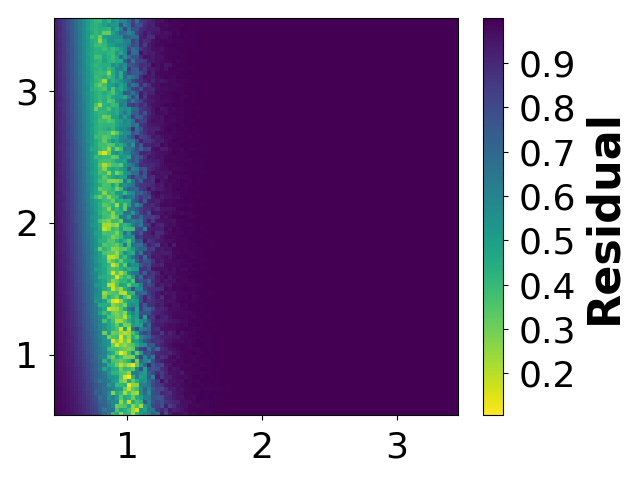

In [16]:
fig2, axes = plt.subplots()
optimization.plot_heatmap('lj-heatmap.pdf')

($\sigma$ is along the x-axis, $\epsilon$ is along the y-axis)

We observe here that there is a narrow range of $\sigma$ values that yield low residuals, hence why most of our optimizations were able to locate the correct value. However, there exists a wide range of $\epsilon$ values that yield low residuals. As a result, even with a very fine grid we are unable to locate the global minimum.